In [1]:
import pyscf
from pyscf import gto,dft,scf

import torch
torch.set_default_dtype(torch.double)
import pyscf
from pyscf import gto,dft,scf

import numpy as np
import scipy
from ase import Atoms
from ase.io import read
from dpyscfl.net import * 
from dpyscfl.scf import * 
from dpyscfl.utils import *
from dpyscfl.losses import *
from pyscf.cc import CCSD
from functools import partial
from ase.units import Bohr
%pylab inline
DEVICE='cpu'

Populating the interactive namespace from numpy and matplotlib


/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['eig']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def get_gamma(rho, s):
    return (s*2*(3*np.pi**2)**(1/3)*rho**(4/3))**2
    
def get_tau(rho, gamma, alpha):
    uniform_factor = (3/10)*(3*np.pi**2)**(2/3)
    return (gamma/(8*rho))+(uniform_factor*rho**(5/3))*alpha

def unpol_input(rho, gamma, tau):
    return .5*rho, .5*rho, 0.25*gamma, 0.25*gamma, 0.25*gamma, 0*tau, 0*tau, 0.5*tau, 0.5*tau

def libxc_input(rho, gamma, tau):
    return rho, torch.sqrt(gamma/3),  torch.sqrt(gamma/3),  torch.sqrt(gamma/3), tau , tau

In [13]:
def plot_fxc(models, rs = [0.1, 1, 5], s_range=[0, 3], alpha_range=None, only = None):
    
    if only is not None:
        saved_models = {}
        for model_name in models:
            gm = models[model_name].grid_models
            saved_models[model_name] = gm
            models[model_name].grid_models = gm[only:only+1]
    if alpha_range is None:
        alpha_range_= [1]
    else:
        alpha_range_= alpha_range
    idx = 0
    for  _, rs_val in enumerate(rs):
        for alpha in alpha_range_:
            rho_val = 3/(4*np.pi*rs_val**3)
            s = torch.linspace(s_range[0], s_range[1],300)
            rho = torch.Tensor([rho_val]*len(s))
            gamma = get_gamma(rho, s)
            tau = get_tau(rho, gamma, alpha)
            
            inp = torch.stack(unpol_input(rho, gamma, tau),dim=-1)
            inp_libxc = torch.stack(libxc_input(rho, gamma,tau),dim=-1).detach().numpy().T
        
            
            e_heg = dft.libxc.eval_xc("LDA_X",inp_libxc,spin=0, deriv=1)[0]
                
            for model_name, ls, lw in zip(models,['-','--',':','-.',':'],[2] + [1]*4):

                if ls == '-' and len(rs) > 1: 
                    l = '$r_s = ${}'.format(rs_val)
                elif ls == '-' and len(alpha_range_) > 1:
                    if alpha_range is not None:
                        l = ' $\\alpha = $ {}'.format(alpha)
                else:
                    l = ''
                libxc = False
                if model_name[-4:] == '_LXC':
                    libxc = True
                if model_name[-2:] == '_S' or libxc:
                    method = models[model_name]
                else:
                    #models[model_name].exx_a = torch.nn.Parameter(torch.Tensor([0]))
                    method = models[model_name].eval_grid_models
                    
                if libxc:
                    exc = dft.libxc.eval_xc(method, inp_libxc, spin=0, deriv=1)[0]
                else:
                    exc = method(inp).squeeze().detach().numpy()
               
               
#                 e_heg = models[model_name].heg_model(rho).squeeze().detach().numpy()
                ax = plot(s, exc/e_heg,
                     label = l, color='C{}'.format(idx),ls = ls,lw=lw)

                if len(rs) == 1 and (alpha_range is None or  len(alpha_range) == 1):
                    idx+=1
            idx+=1
            
    for idx,(model_name, ls) in enumerate(zip(models,['-','--',':','-.',':'])):  
        c = 'gray' if len(rs) > 1 or len(alpha_range_) > 1 else 'C{}'.format(idx)
        plot([],label=model_name,color=c,ls=ls)

    ylabel('$F_{xc}$ (a.u.)')
    xlabel('s')
    legend()
    
    if only is not None:
        for model_name in models:
            models[model_name].grid_models = saved_models[model_name]

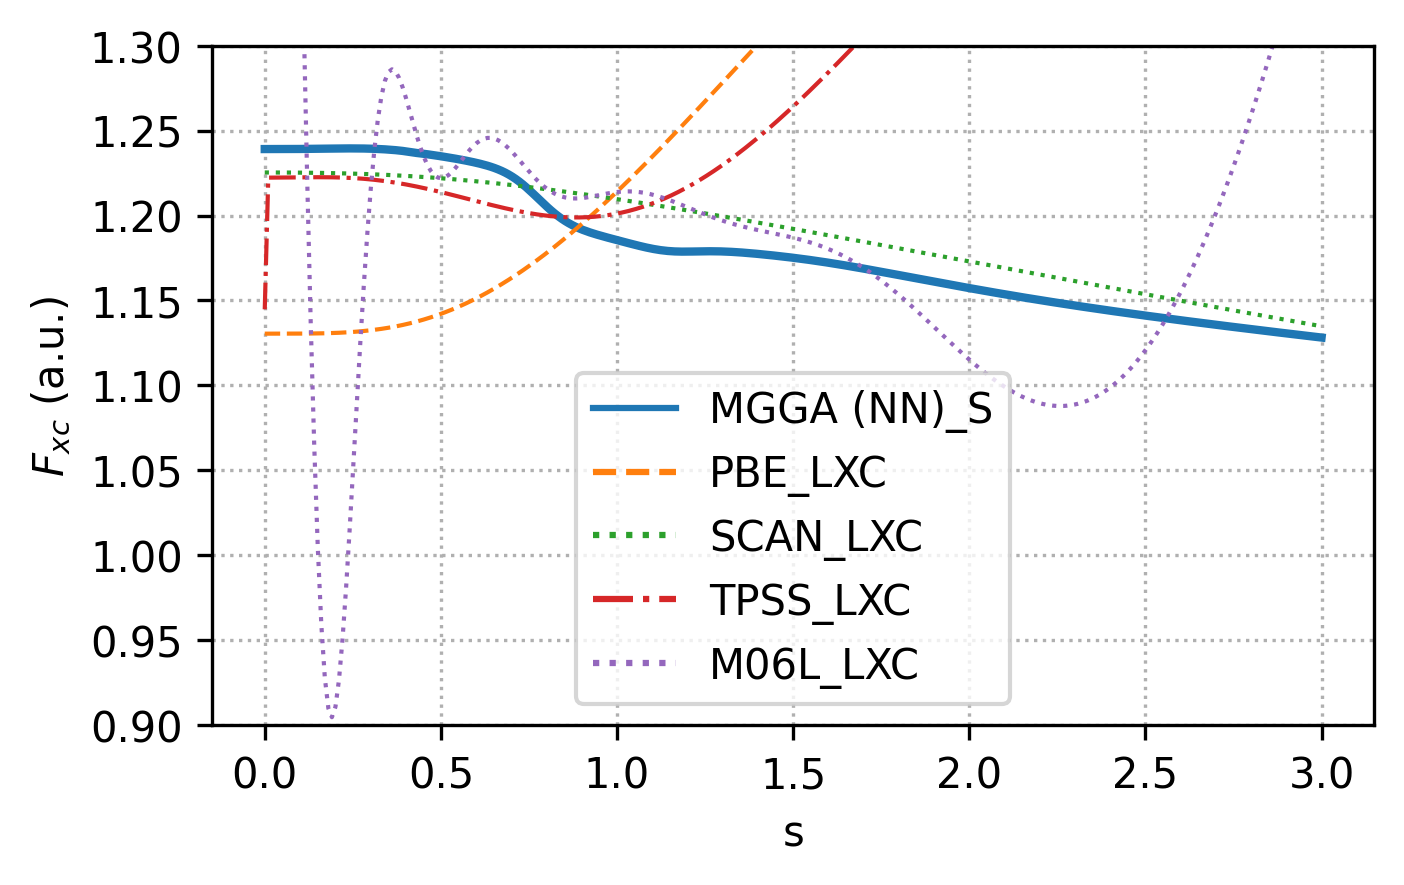

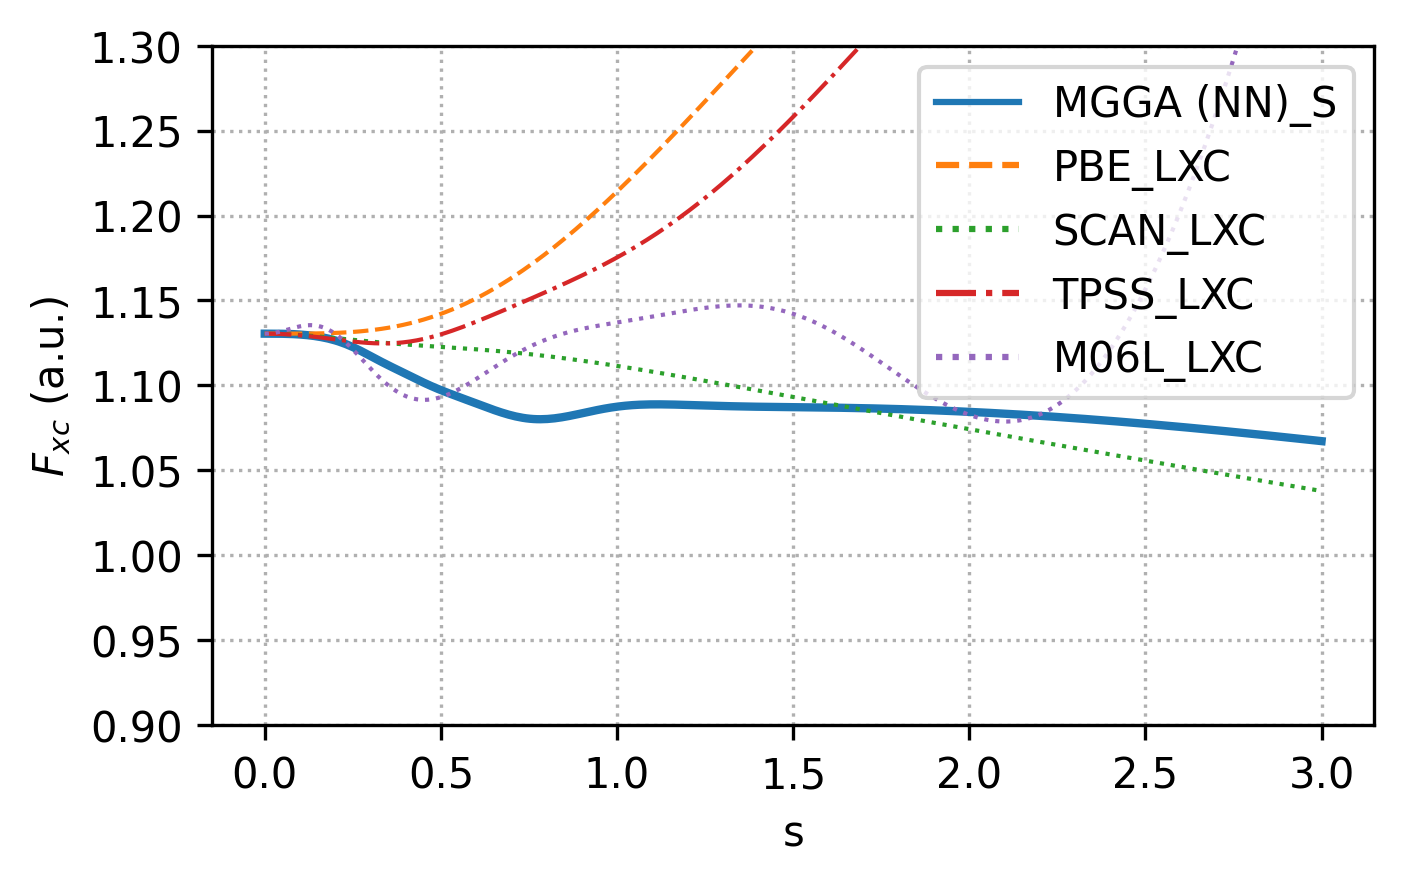

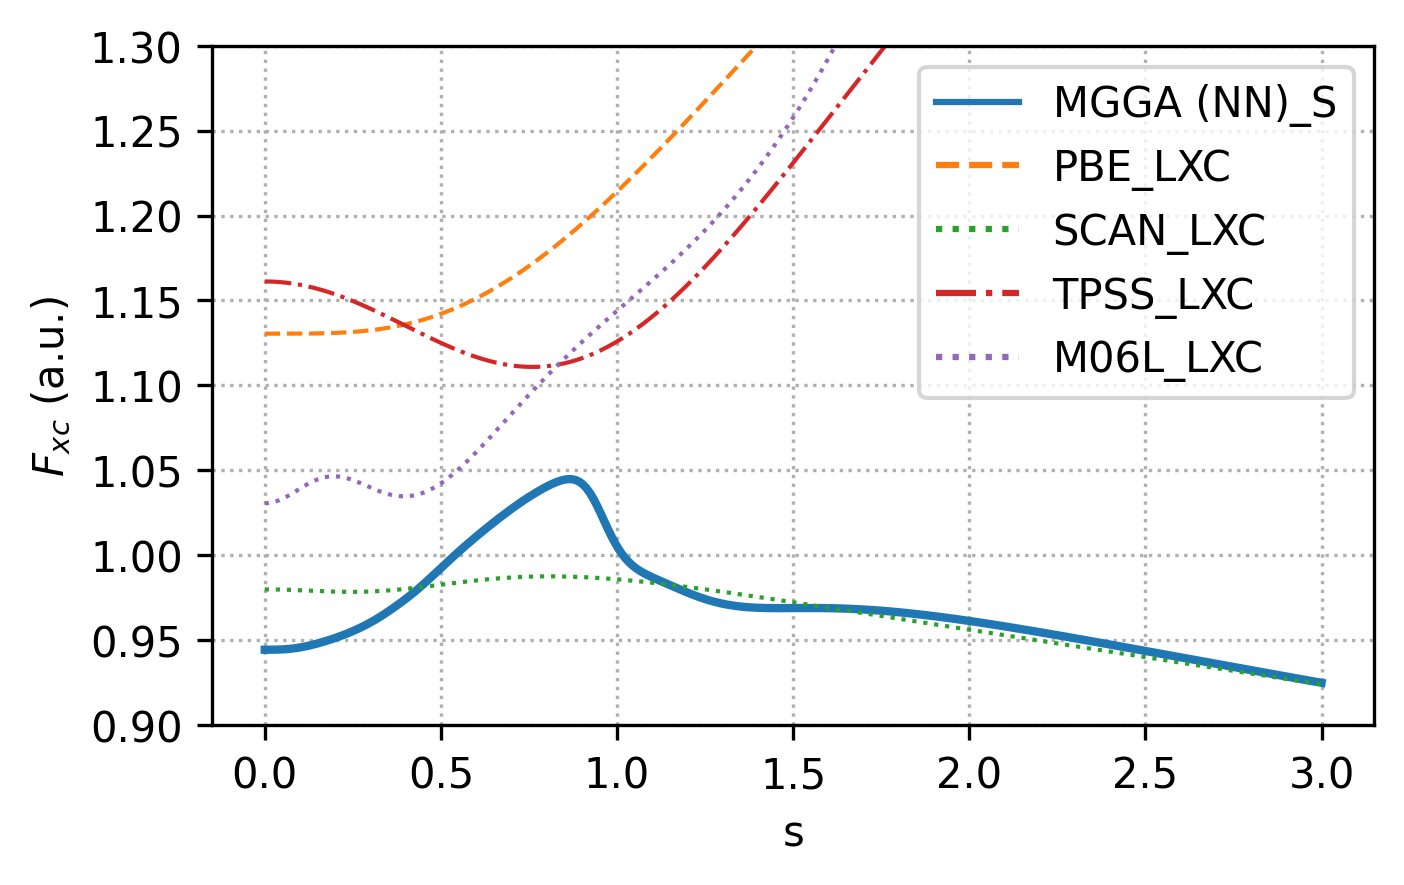

In [4]:
figsize(5,3)

figure(dpi=300)
xc_s = torch.jit.load('/home/awills/Documents/Research/xcdiff/models/final/log_mgga_reaction2/MGGA_REACTION2/xc')
plot_fxc({"MGGA (NN)_S": xc_s, 
          "PBE_LXC":"GGA_X_PBE, GGA_C_PBE",
          'SCAN_LXC':"MGGA_X_SCAN, MGGA_C_SCAN",
          'TPSS_LXC':"MGGA_X_TPSS, MGGA_C_TPSS",
          'M06L_LXC':"MGGA_X_M06L, MGGA_C_M06L"}, s_range=[0, 3], rs=[1], alpha_range=[0])
ylim(0.9,1.3)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha0.pdf',bbox_inches='tight')
figure(dpi=300)
plot_fxc({"MGGA (NN)_S": xc_s, 
          "PBE_LXC":"GGA_X_PBE, GGA_C_PBE",
          'SCAN_LXC':"MGGA_X_SCAN, MGGA_C_SCAN",
          'TPSS_LXC':"MGGA_X_TPSS, MGGA_C_TPSS",
          'M06L_LXC':"MGGA_X_M06L, MGGA_C_M06L"}, s_range=[0, 3], rs=[1], alpha_range=[1])
ylim(0.9,1.3)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha1.pdf',bbox_inches='tight')
figure(dpi=300)
plot_fxc({"MGGA (NN)_S": xc_s, 
          "PBE_LXC":"GGA_X_PBE, GGA_C_PBE",
          'SCAN_LXC':"MGGA_X_SCAN, MGGA_C_SCAN",
          'TPSS_LXC':"MGGA_X_TPSS, MGGA_C_TPSS",
          'M06L_LXC':"MGGA_X_M06L, MGGA_C_M06L"}, s_range=[0, 3], rs=[1], alpha_range=[10])
ylim(0.9,1.3)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha10.pdf',bbox_inches='tight')

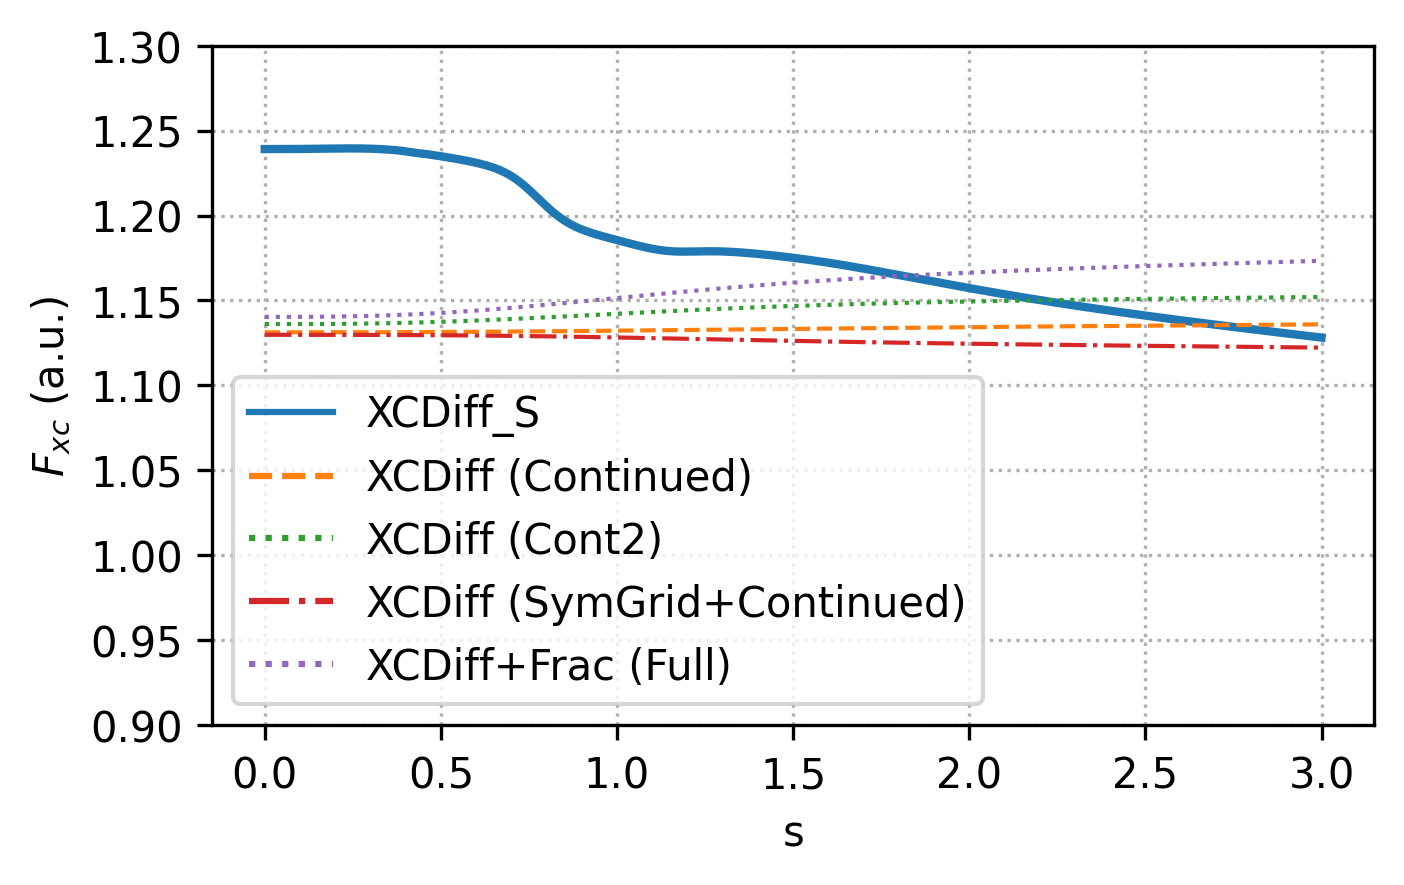

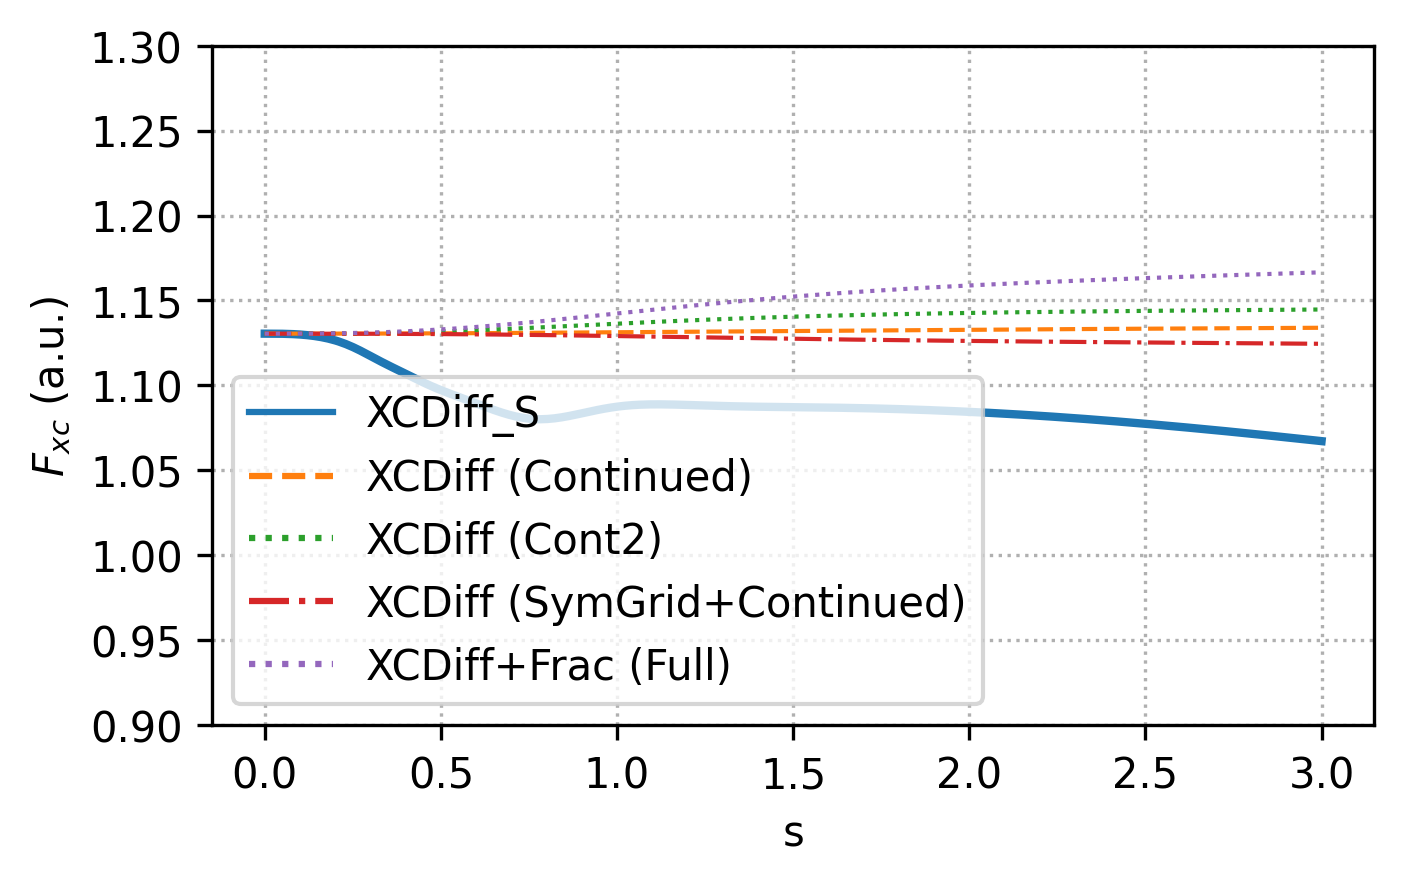

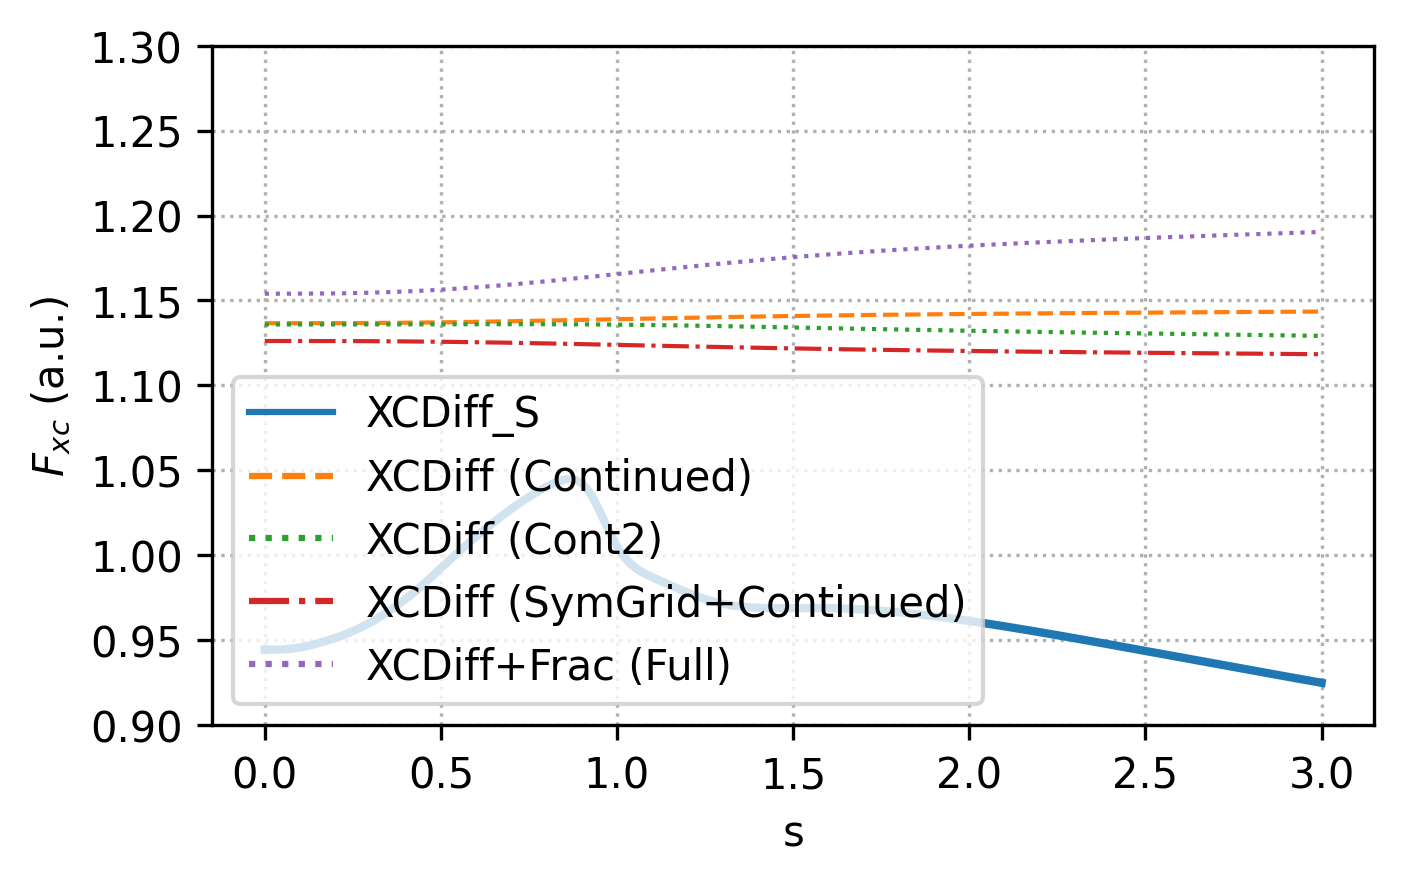

In [5]:
figsize(5,3)

figure(dpi=300)
modelroot = '/home/awills/Documents/Research/swxcd/eval'
xcd = torch.jit.load(os.path.join(modelroot, 'xcdiff/MODEL_MGGA/xc'))
xcdc = torch.load(os.path.join(modelroot, 'xcdiff/MODEL_MGGA_3/xc'))
xcd2 = torch.load('/home/awills/Documents/Research/swxcd/train/xcdiff_2/2022-05-12_15:43:30.185601_current.pt')
xcds = torch.load('/home/awills/Documents/Research/swxcd/train/xcdiffsym/2022-05-16_19:05:42.136972_2.pt')
xcdf = torch.load(os.path.join(modelroot, 'rxnfrac/MODEL_MGGA/xc'))
xcdfa = torch.load(os.path.join(modelroot, 'fa_rxnfrac/MODEL_MGGA/xc'))
xcdfa1 = torch.load(os.path.join(modelroot, 'fa1_rxnfrac/MODEL_MGGA/xc'))
xcdfa2 = torch.load(os.path.join(modelroot, 'fa2_rxnfrac/MODEL_MGGA/xc'))

dct = {"XCDiff_S": xcd, 
          "XCDiff (Continued)":xcdc.xc,
          "XCDiff (Cont2)":xcd2.xc,
          "XCDiff (SymGrid+Continued)": xcds.xc,
          "XCDiff+Frac (Full)":xcdf.xc,
          'XCDiff+Frac (Inserted)':xcdfa.xc,
          'XCDiff+Frac (Insert+Output)':xcdfa1.xc,
          'XCDiff+Frac (Insert+Output, e_len)':xcdfa2.xc}
plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[0])
ylim(0.9,1.3)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha0.pdf',bbox_inches='tight')
figure(dpi=300)
plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[1])
ylim(0.9,1.3)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha1.pdf',bbox_inches='tight')
figure(dpi=300)
plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[10])
ylim(0.9,1.3)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha10.pdf',bbox_inches='tight')

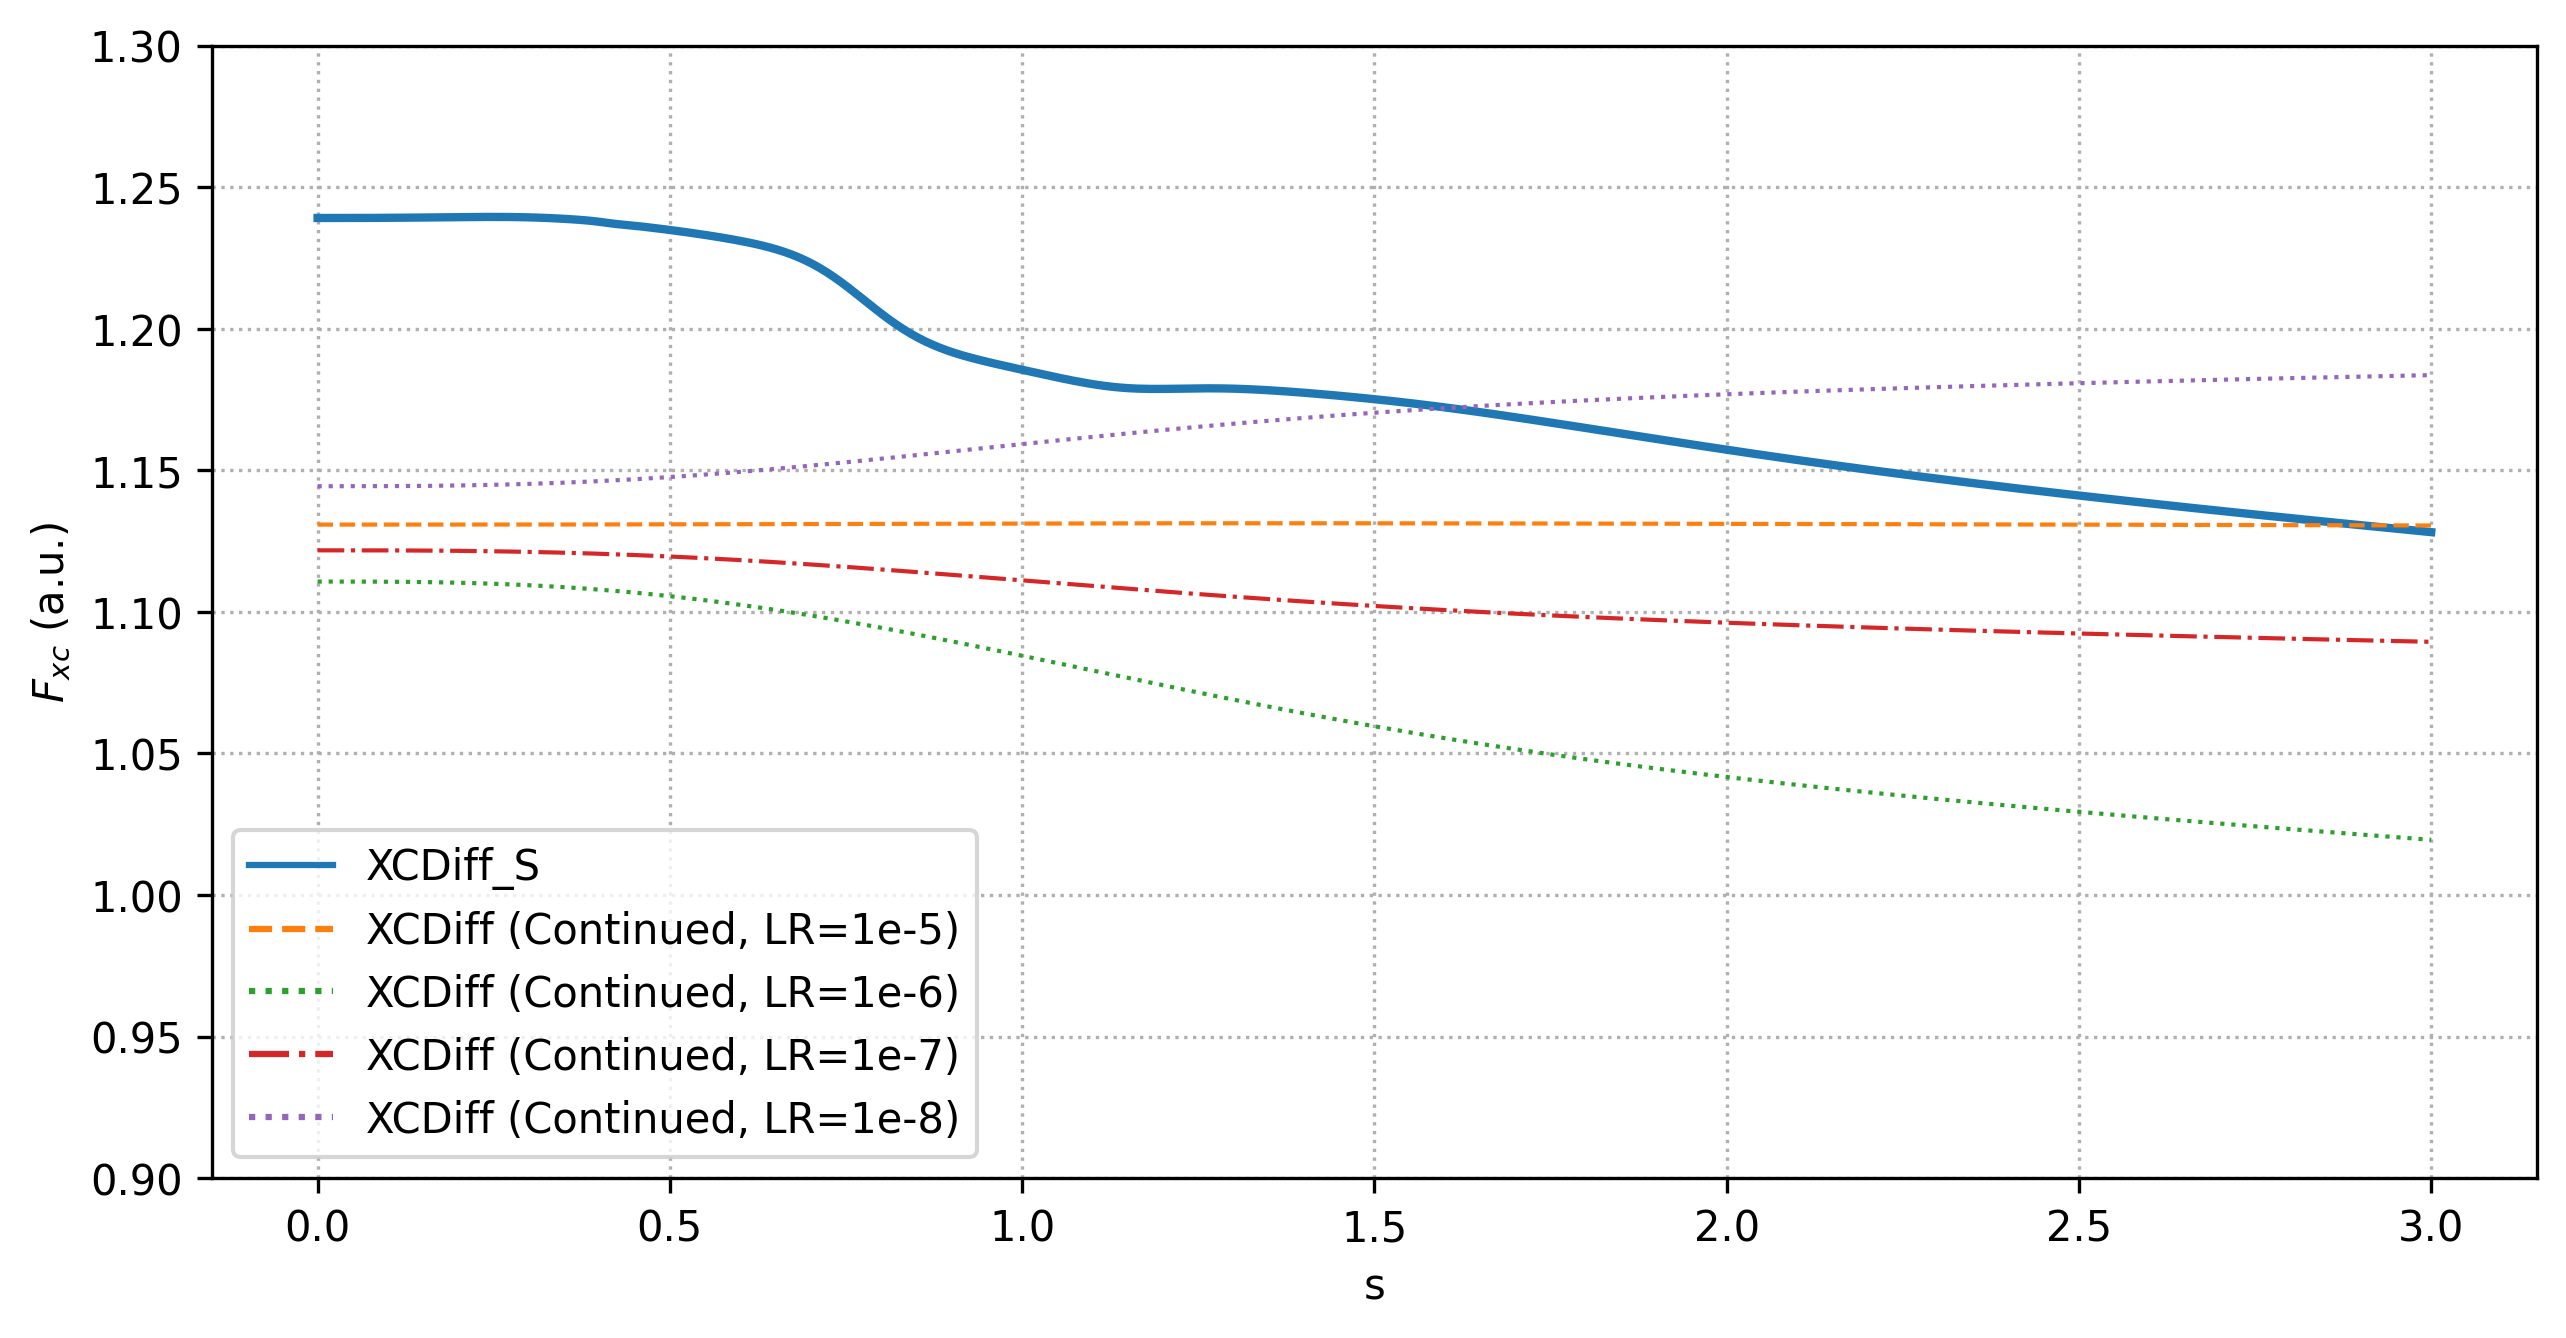

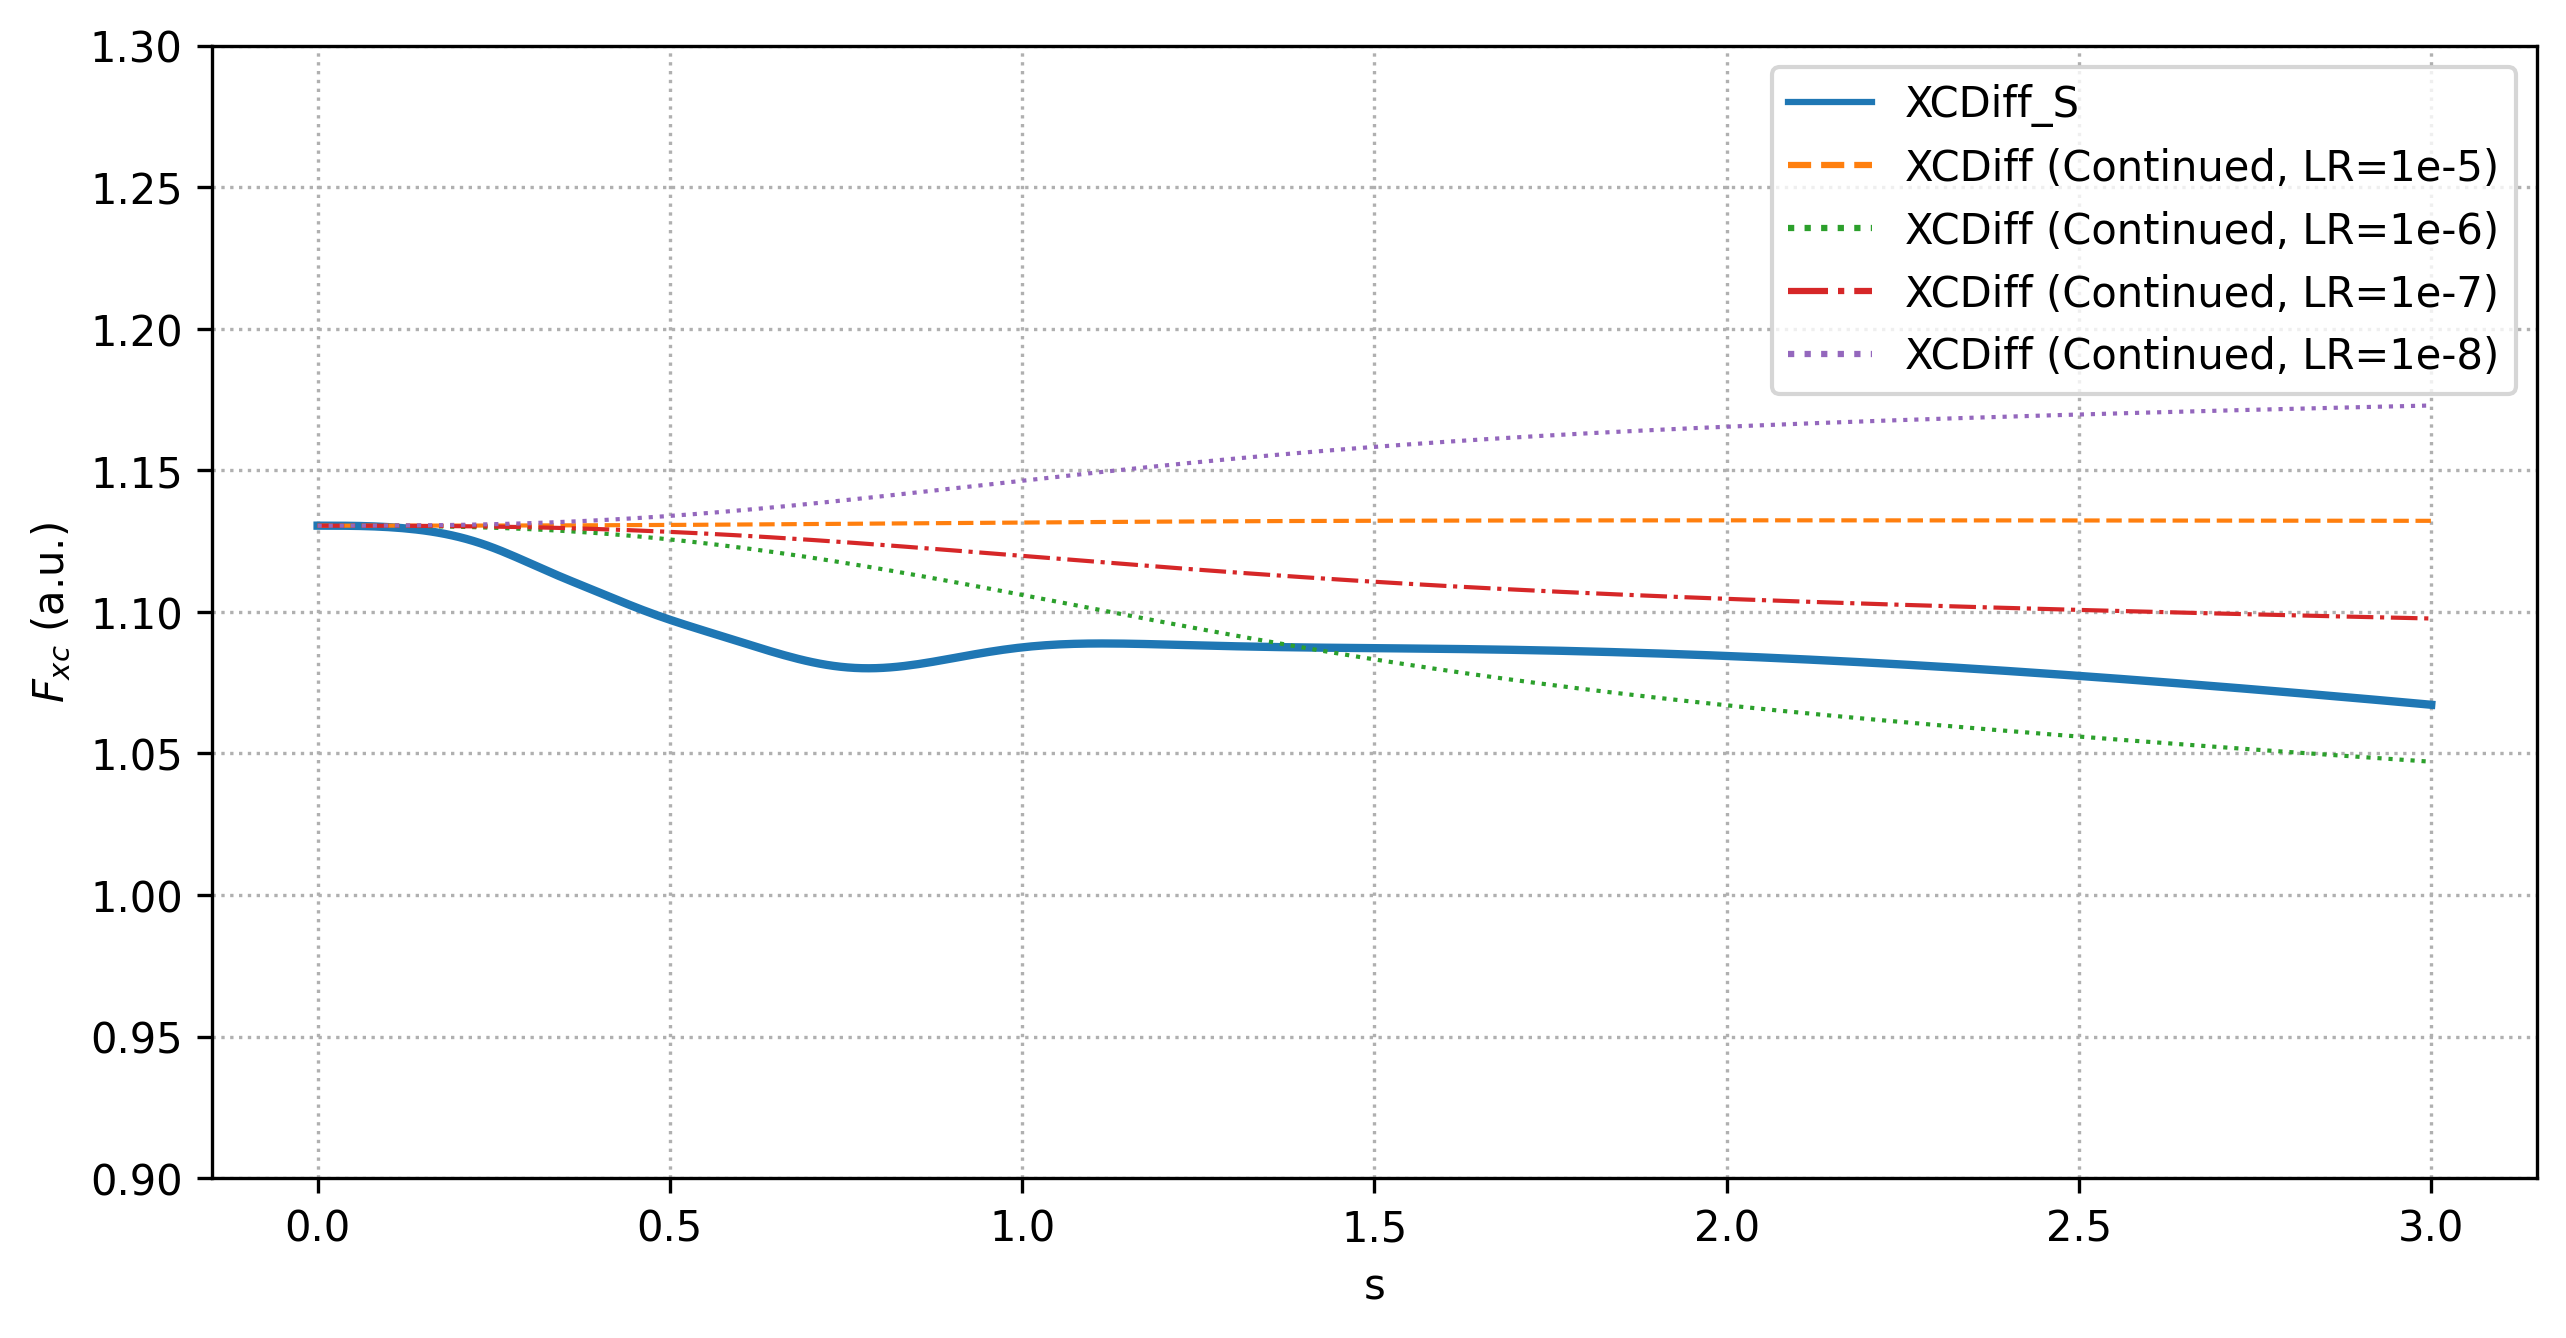

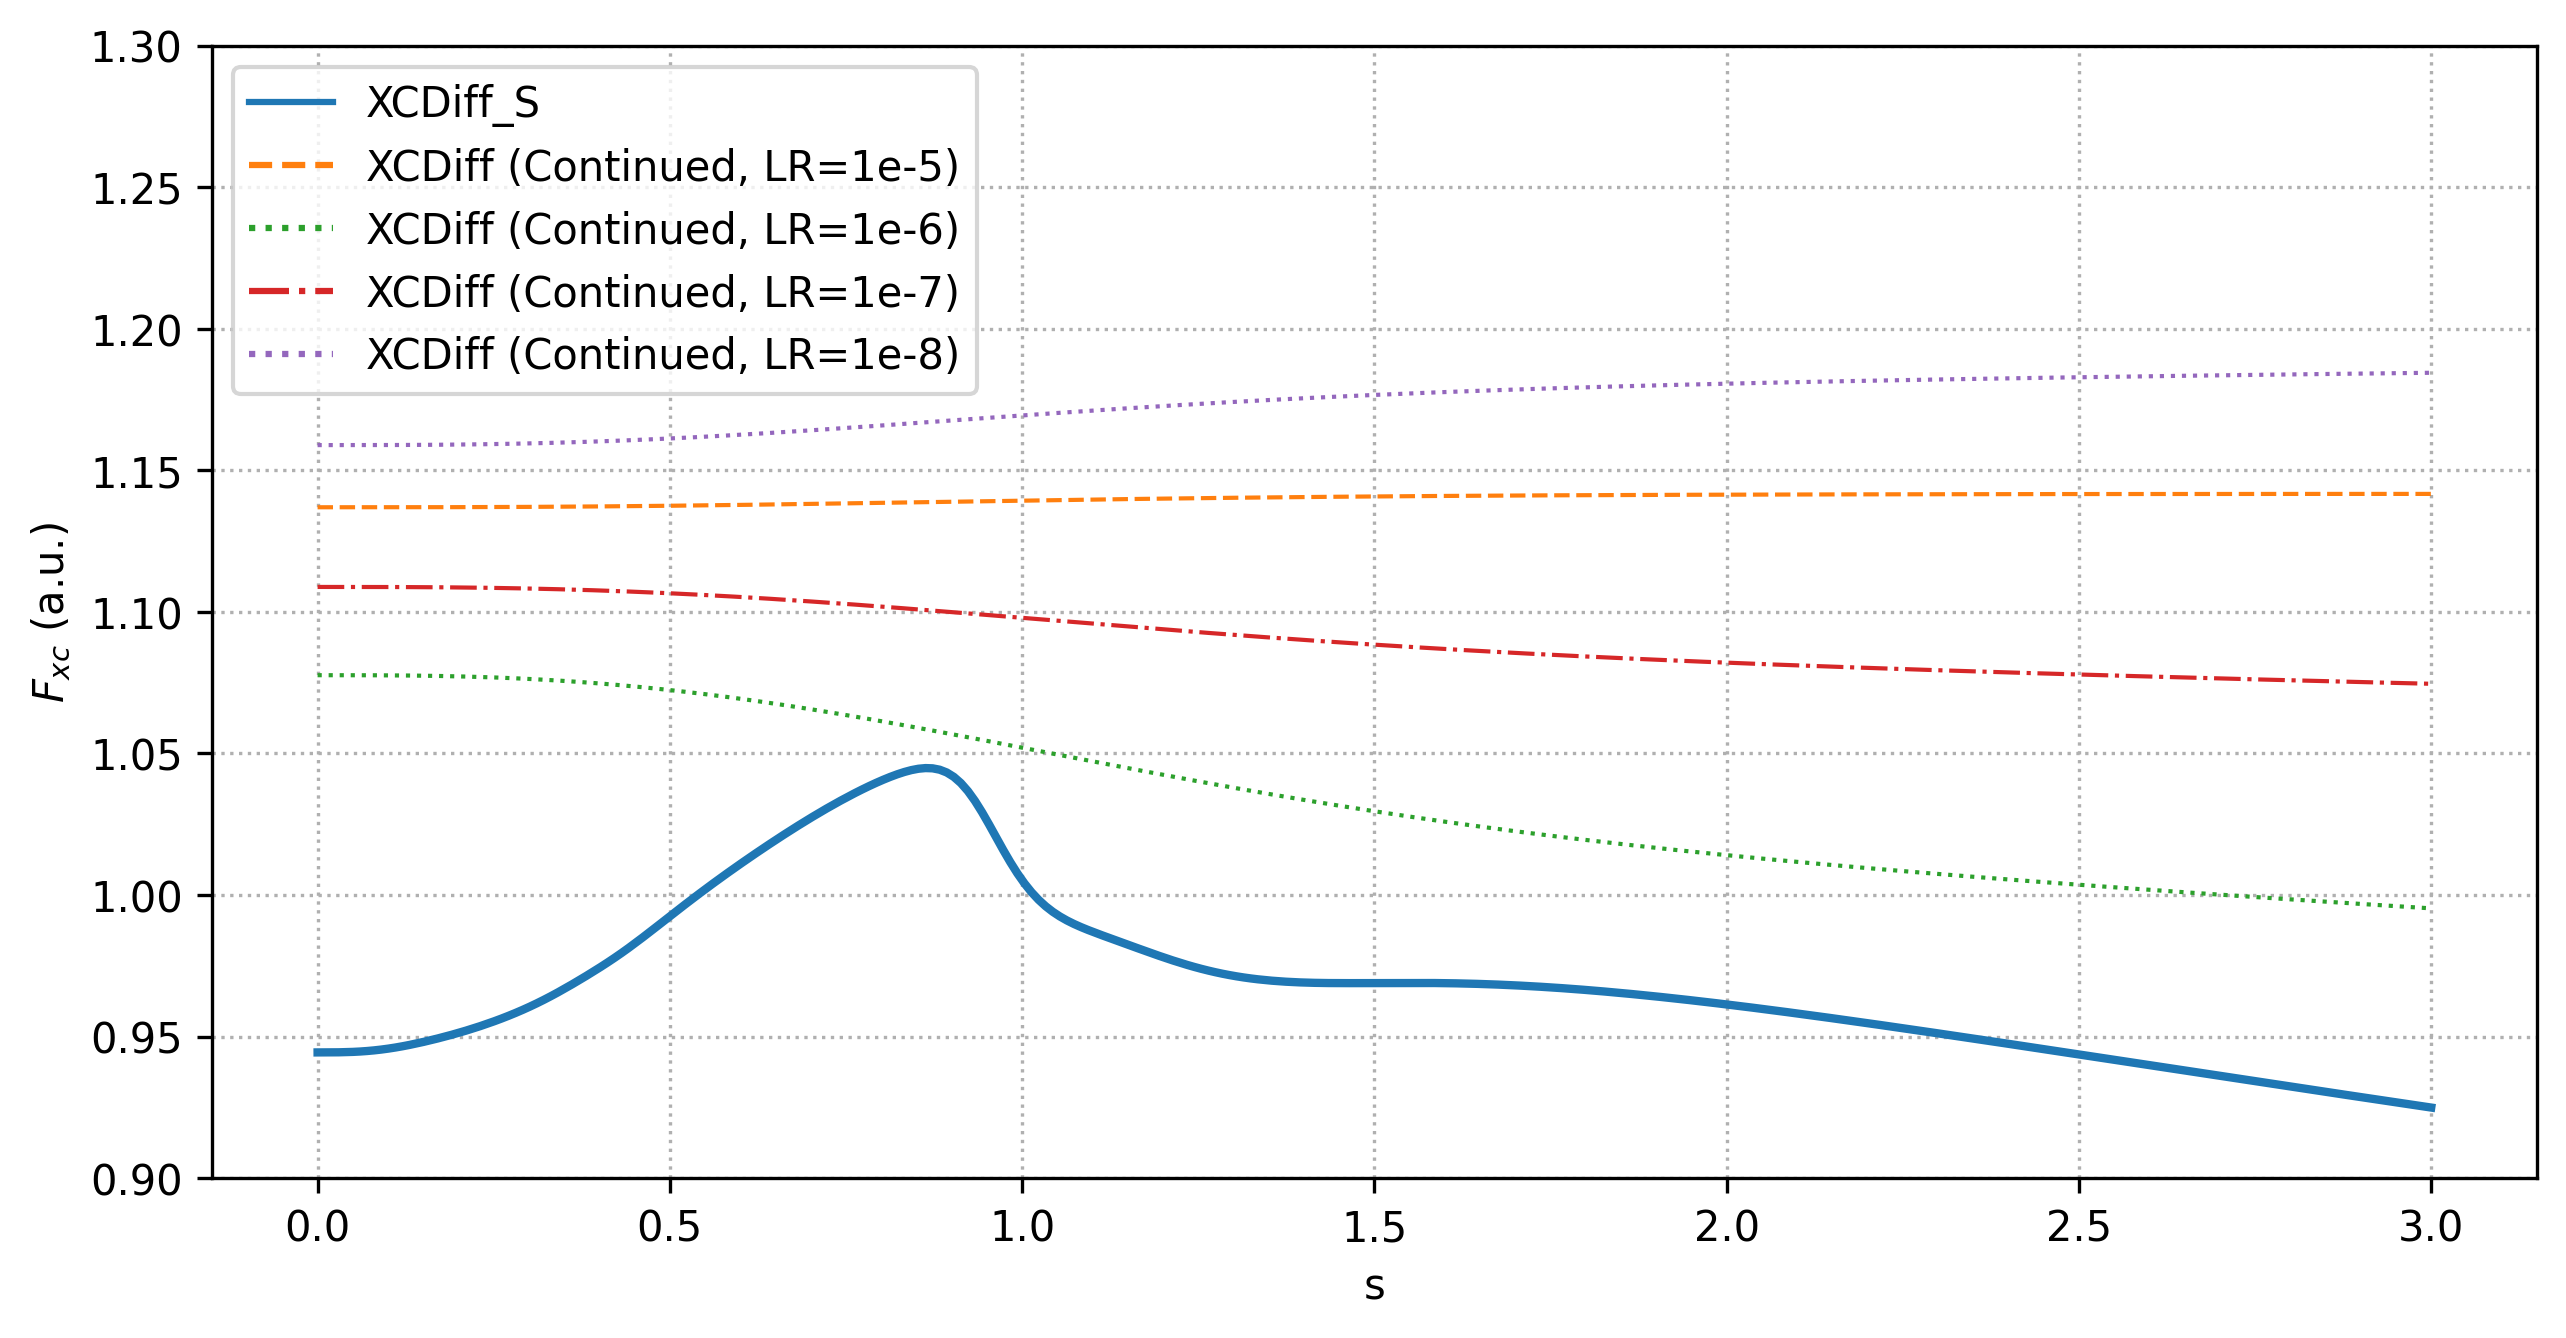

In [11]:
figsize(10,5)

figure(dpi=300)
modelroot = '/home/awills/Documents/Research/swxcd/eval'
xcdsd = '/home/awills/Documents/Research/swxcd/train/xcdiffsym'
xcd = torch.jit.load(os.path.join(modelroot, 'xcdiff/MODEL_MGGA/xc'))
xcd4 = torch.load(os.path.join(xcdsd, 'lr1en4', 'xc'))
xcd5 = torch.load(os.path.join(xcdsd, 'lr1en5', 'xc'))
xcd6 = torch.load(os.path.join(xcdsd, 'lr1en6', 'xc'))
xcd7 = torch.load(os.path.join(xcdsd, 'lr1en7', 'xc'))
xcd8 = torch.load(os.path.join(xcdsd, 'lr1en8', 'xc'))

only = None

dct = {"XCDiff_S": xcd, 
        #"XCDiff (Continued, LR=1e-4)":xcd4.xc,
      "XCDiff (Continued, LR=1e-5)":xcd5.xc,
      "XCDiff (Continued, LR=1e-6)":xcd6.xc,
      "XCDiff (Continued, LR=1e-7)":xcd7.xc,
      "XCDiff (Continued, LR=1e-8)":xcd8.xc,}

plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[0], only=only)
ylim(0.9,1.3)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha0.pdf',bbox_inches='tight')
figure(dpi=300)
plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[1], only=only)
ylim(0.9,1.3)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha1.pdf',bbox_inches='tight')
figure(dpi=300)
plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[10], only=only)
ylim(0.9,1.3)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha10.pdf',bbox_inches='tight')

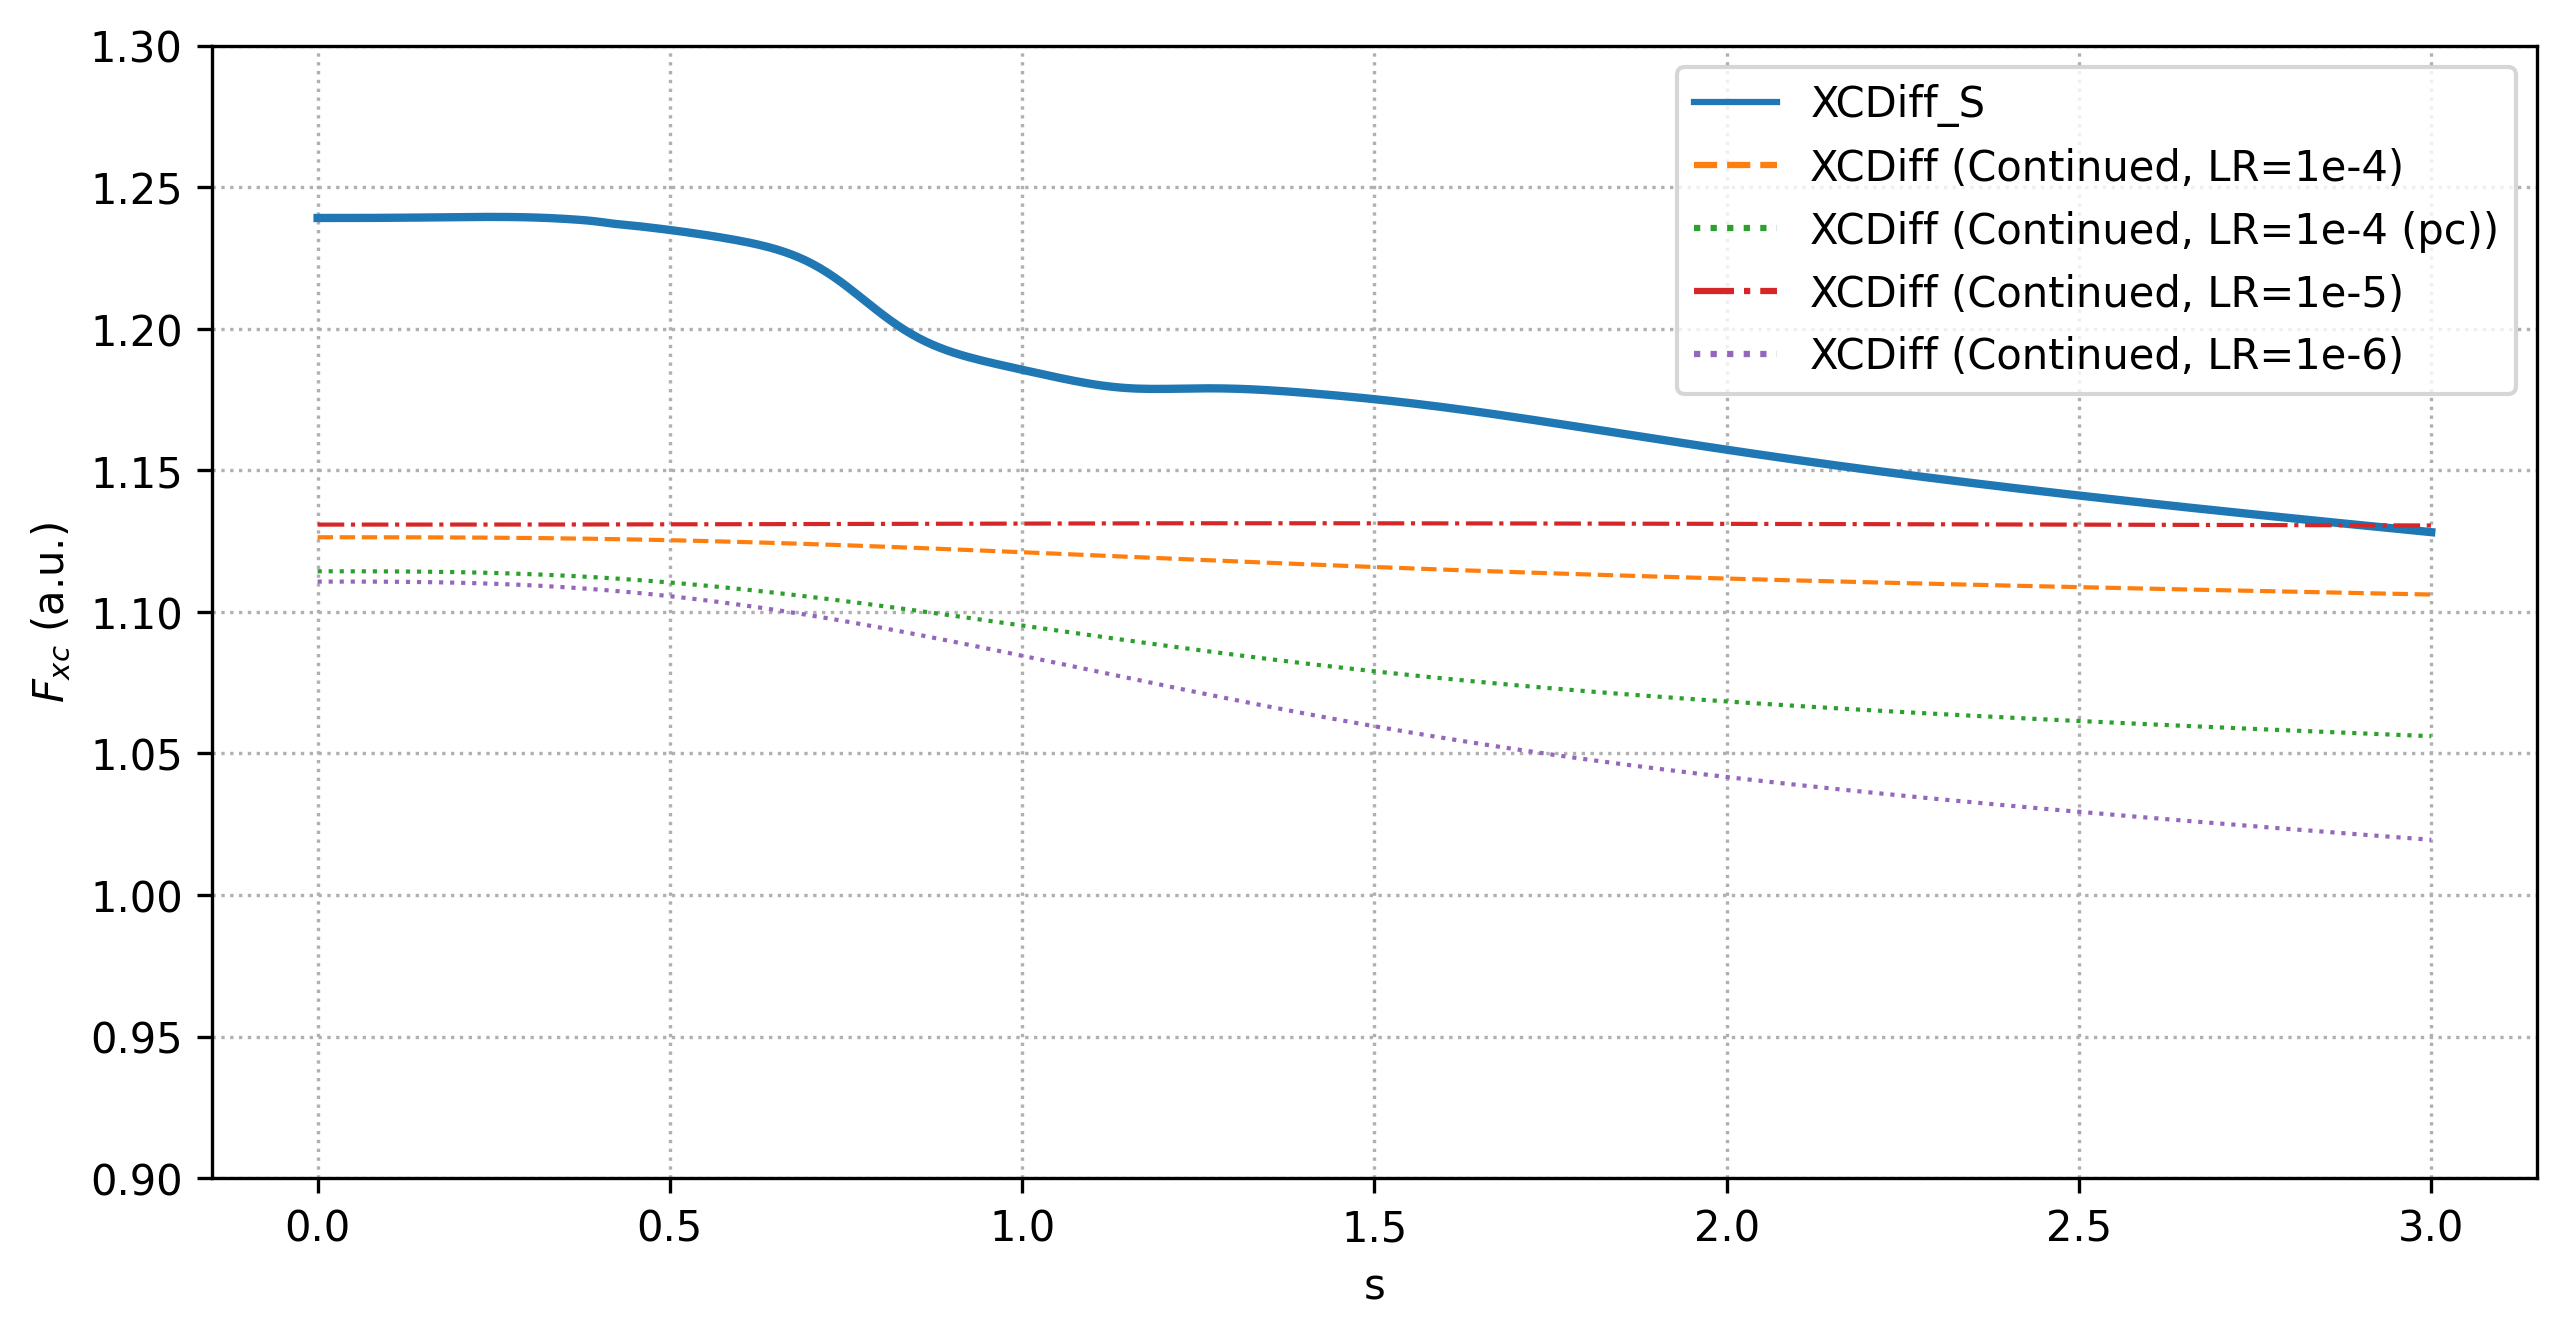

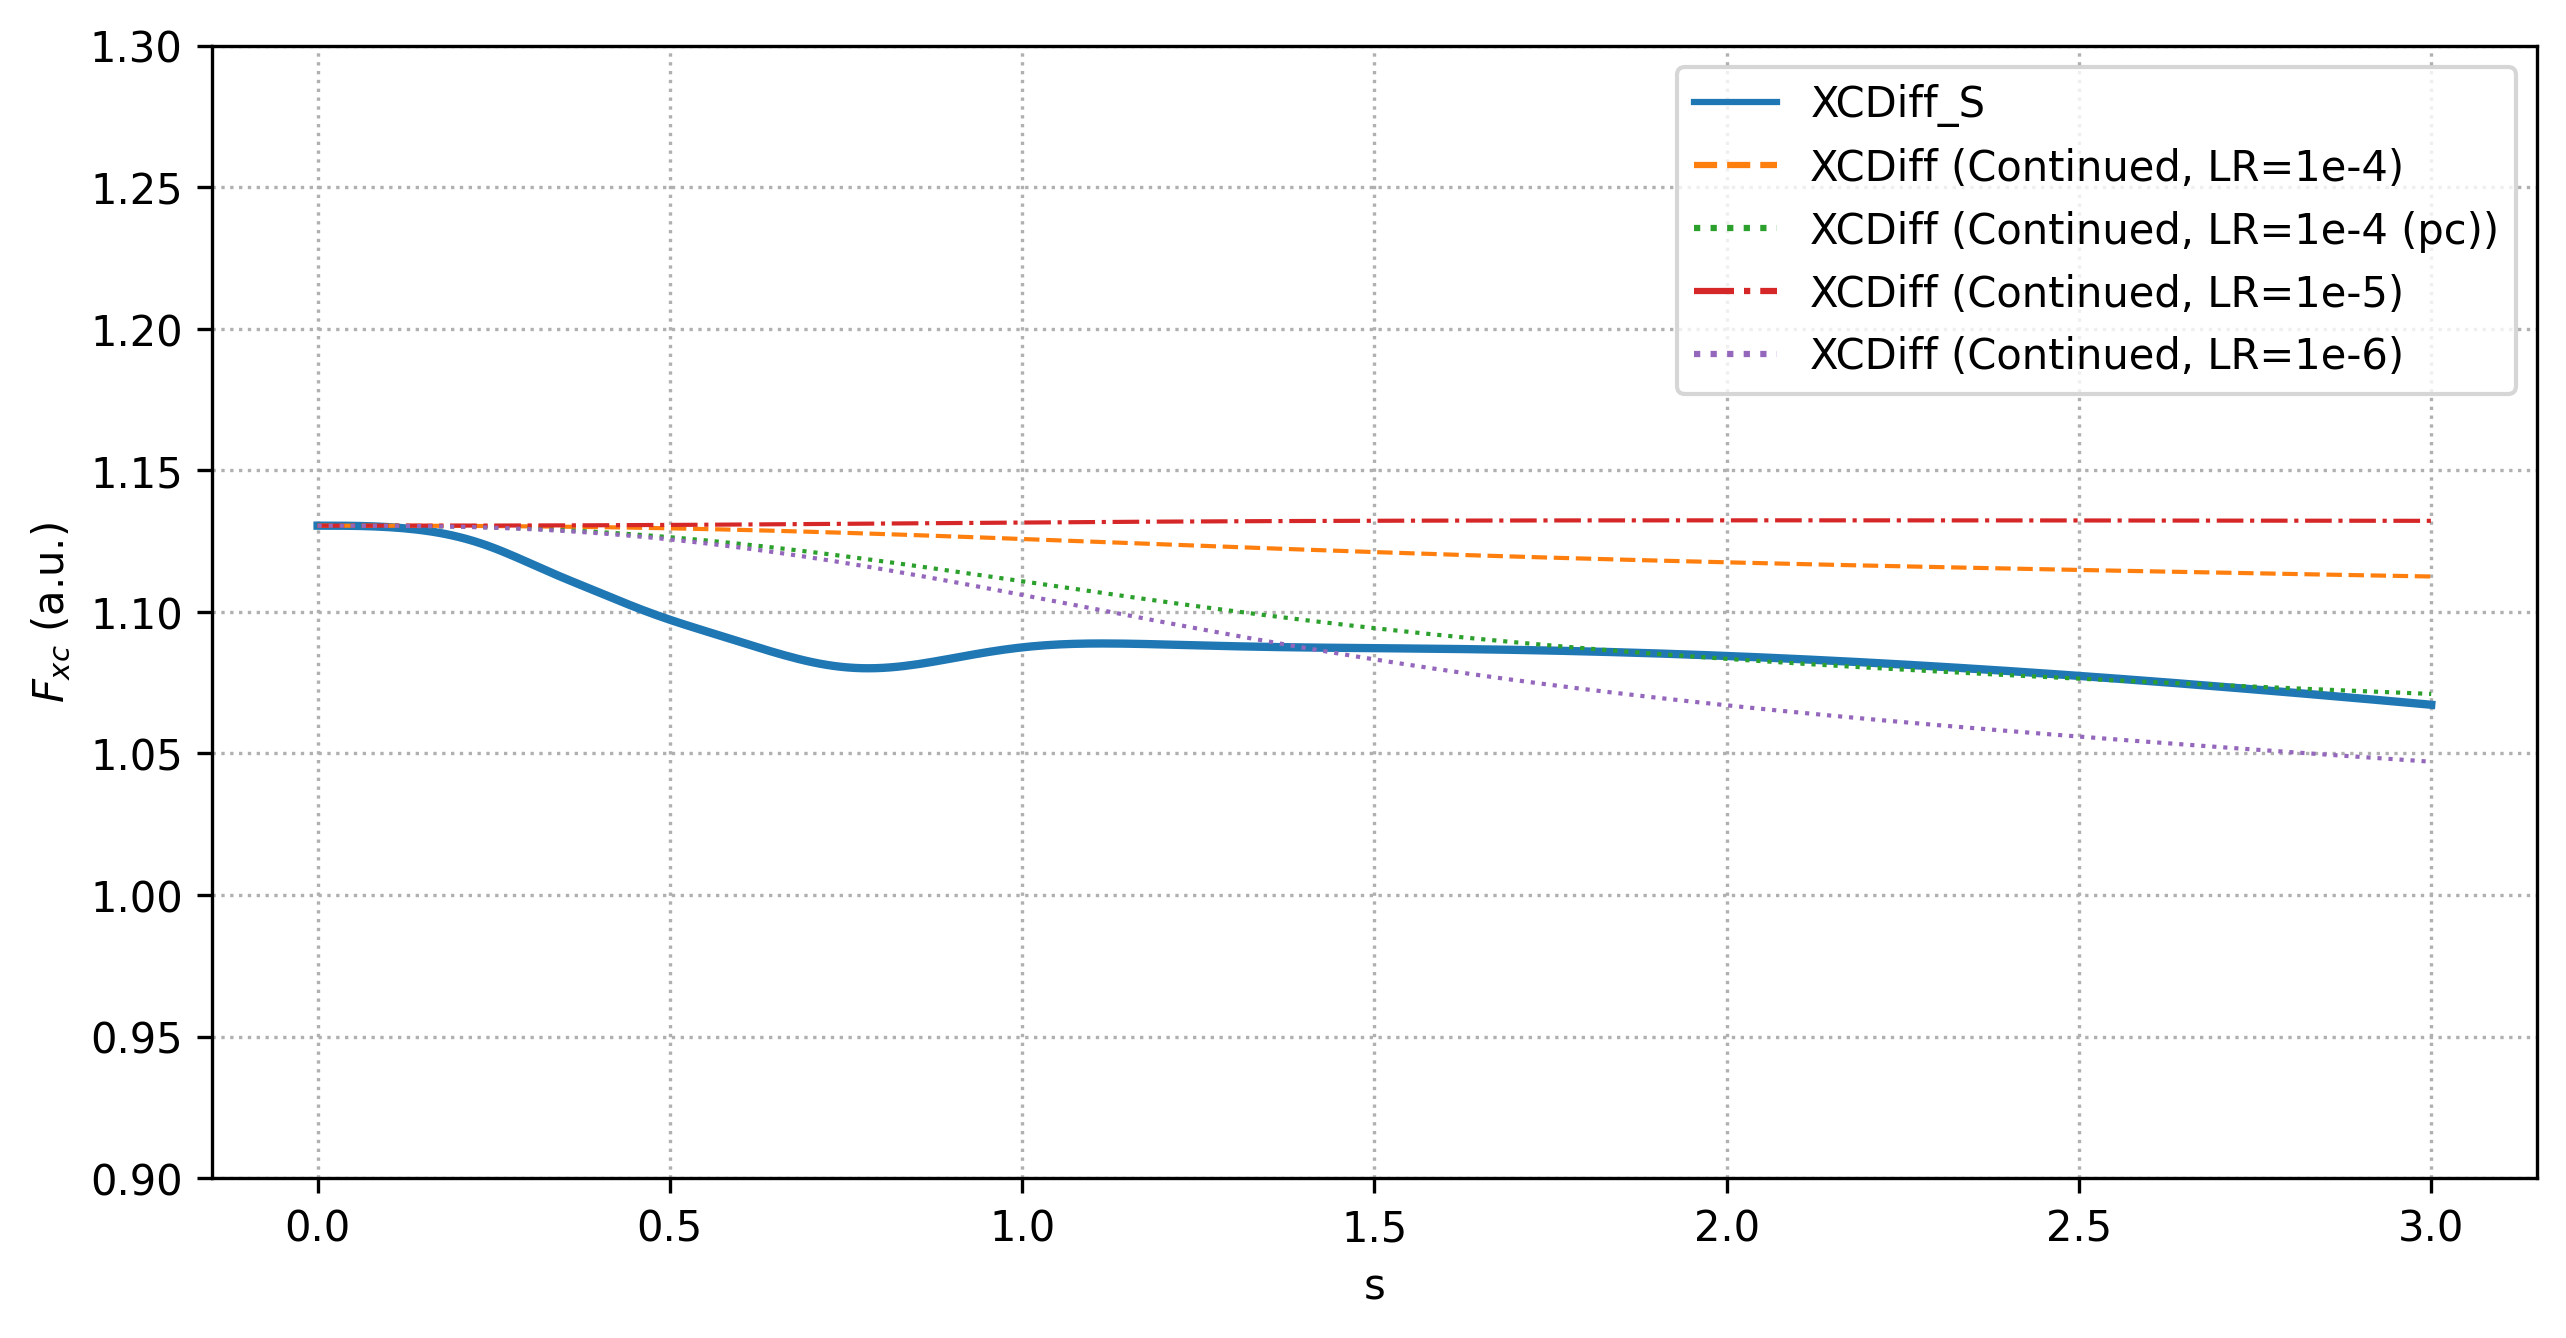

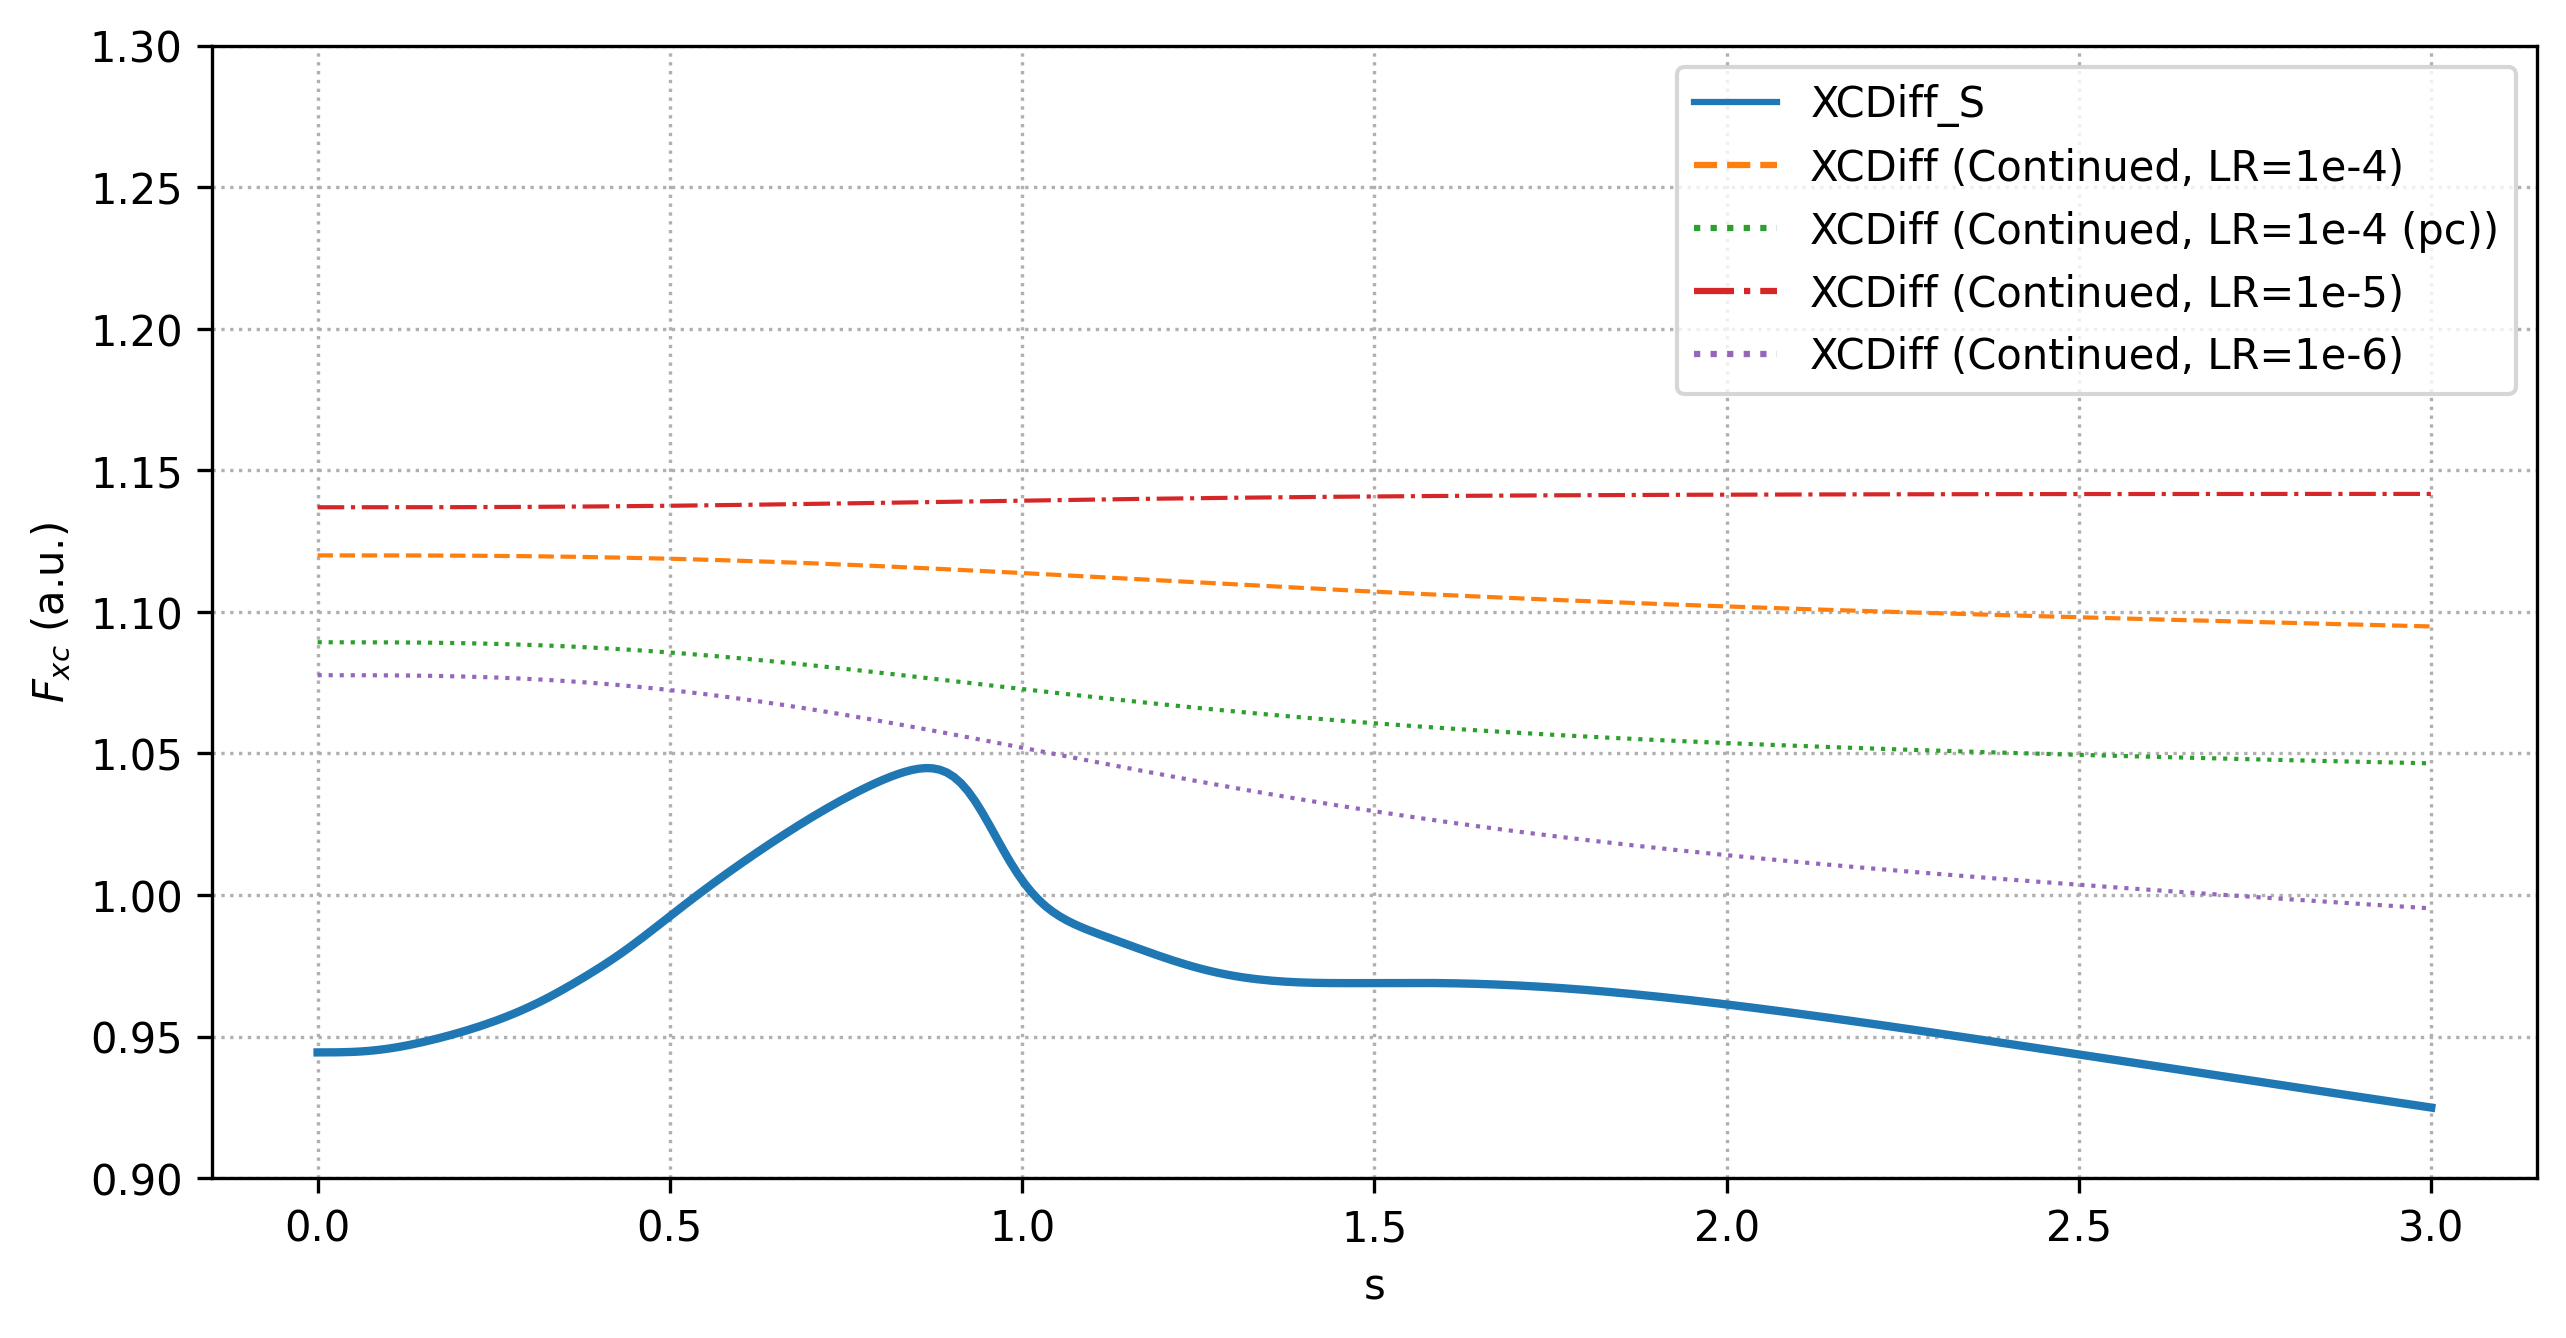

In [19]:
figsize(10,5)

figure(dpi=300)
modelroot = '/home/awills/Documents/Research/swxcd/eval'
xcdsd = '/home/awills/Documents/Research/swxcd/train/xcdiffsym'
xcd = torch.jit.load(os.path.join(modelroot, 'xcdiff/MODEL_MGGA/xc'))
xcd4 = torch.load(os.path.join(xcdsd, 'lr1en4', 'xc'))
xcd4pc = torch.load(os.path.join(xcdsd, 'lr1en4_pc', 'xc'))
xcd5 = torch.load(os.path.join(xcdsd, 'lr1en5', 'xc'))
xcd6 = torch.load(os.path.join(xcdsd, 'lr1en6', 'xc'))
xcd7 = torch.load(os.path.join(xcdsd, 'lr1en7', 'xc'))
xcd8 = torch.load(os.path.join(xcdsd, 'lr1en8', 'xc'))

only = None
ylims=(0.9, 1.3)
dct = {"XCDiff_S": xcd, 
        "XCDiff (Continued, LR=1e-4)":xcd4.xc,
        "XCDiff (Continued, LR=1e-4 (pc))":xcd4pc.xc,
      "XCDiff (Continued, LR=1e-5)":xcd5.xc,
      "XCDiff (Continued, LR=1e-6)":xcd6.xc,
      "XCDiff (Continued, LR=1e-7)":xcd7.xc,
      "XCDiff (Continued, LR=1e-8)":xcd8.xc,}

plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[0], only=only)
ylim(ylims)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha0.pdf',bbox_inches='tight')
figure(dpi=300)
plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[1], only=only)
ylim(ylims)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha1.pdf',bbox_inches='tight')
figure(dpi=300)
plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[10], only=only)
ylim(ylims)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha10.pdf',bbox_inches='tight')

In [9]:
figsize(10,5)

figure(dpi=300)
modelroot = '/home/awills/Documents/Research/swxcd/eval'
xcdsd = '/home/awills/Documents/Research/swxcd/train/xcdiffsym'
xcd = torch.jit.load(os.path.join(modelroot, 'xcdiff/MODEL_MGGA/xc'))
xcd4 = torch.load(os.path.join(xcdsd, 'lr1en4', 'xc'))
xcd4pc = torch.load(os.path.join(xcdsd, 'lr1en4_pc', 'xc'))
xcd4pc2 = torch.load(os.path.join(xcdsd, 'lr1en4_pc2', 'xc'))
xcd5 = torch.load(os.path.join(xcdsd, 'lr1en5', 'xc'))
xcd6 = torch.load(os.path.join(xcdsd, 'lr1en6', 'xc'))
xcd7 = torch.load(os.path.join(xcdsd, 'lr1en7', 'xc'))
xcd8 = torch.load(os.path.join(xcdsd, 'lr1en8', 'xc'))

only = None
ylims=(1, 1.15)
dct = {"XCDiff_S": xcd, 
        #"XCDiff (Continued, LR=1e-4)":xcd4.xc,
        #"XCDiff (Continued, LR=1e-4 (pc))":xcd4pc.xc,
        "XCDiff (Continued, LR=1e-4 (pc2))":xcd4pc2.xc,
      #"XCDiff (Continued, LR=1e-5)":xcd5.xc,
      #"XCDiff (Continued, LR=1e-6)":xcd6.xc,
      #"XCDiff (Continued, LR=1e-7)":xcd7.xc,
      #"XCDiff (Continued, LR=1e-8)":xcd8.xc,
      }

plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[0], only=only)
ylim(ylims)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha0.pdf',bbox_inches='tight')
figure(dpi=300)
plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[1], only=only)
ylim(ylims)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha1.pdf',bbox_inches='tight')
figure(dpi=300)
plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[10], only=only)
ylim(ylims)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha10.pdf',bbox_inches='tight')

AttributeError: Can't get attribute 'X_L' on <module 'dpyscfl.net' from '/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/dpyscfl/net.py'>

<Figure size 3000x1500 with 0 Axes>

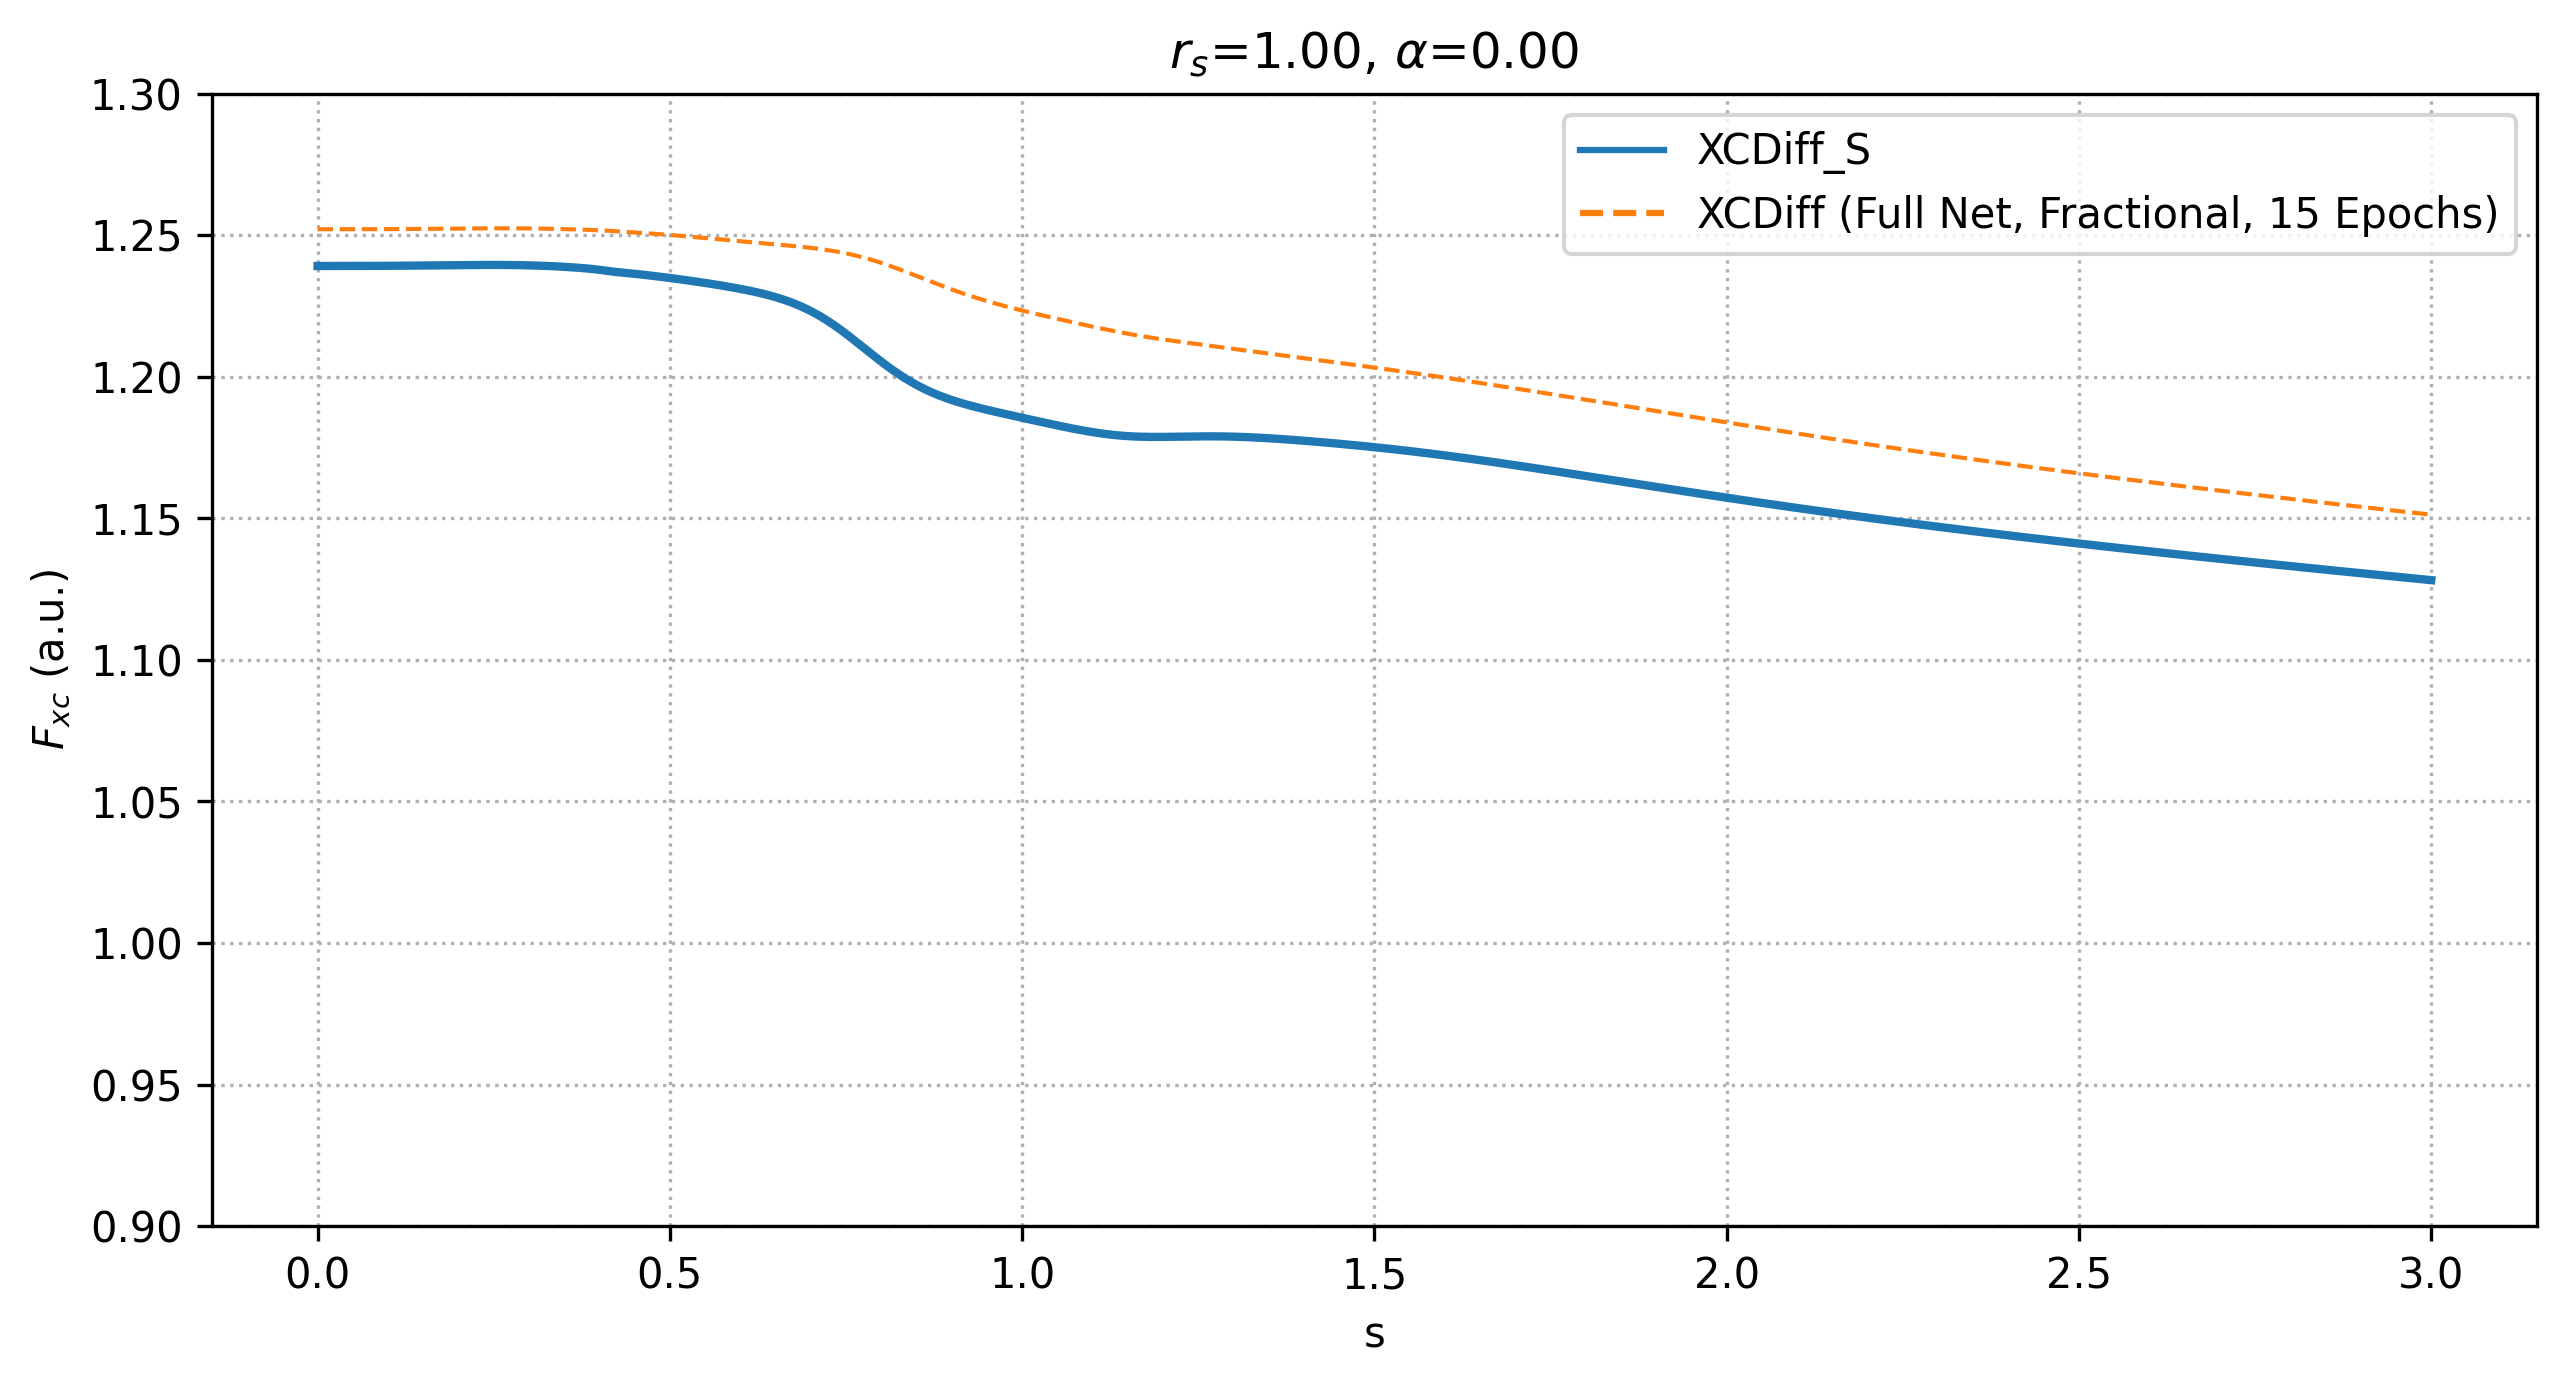

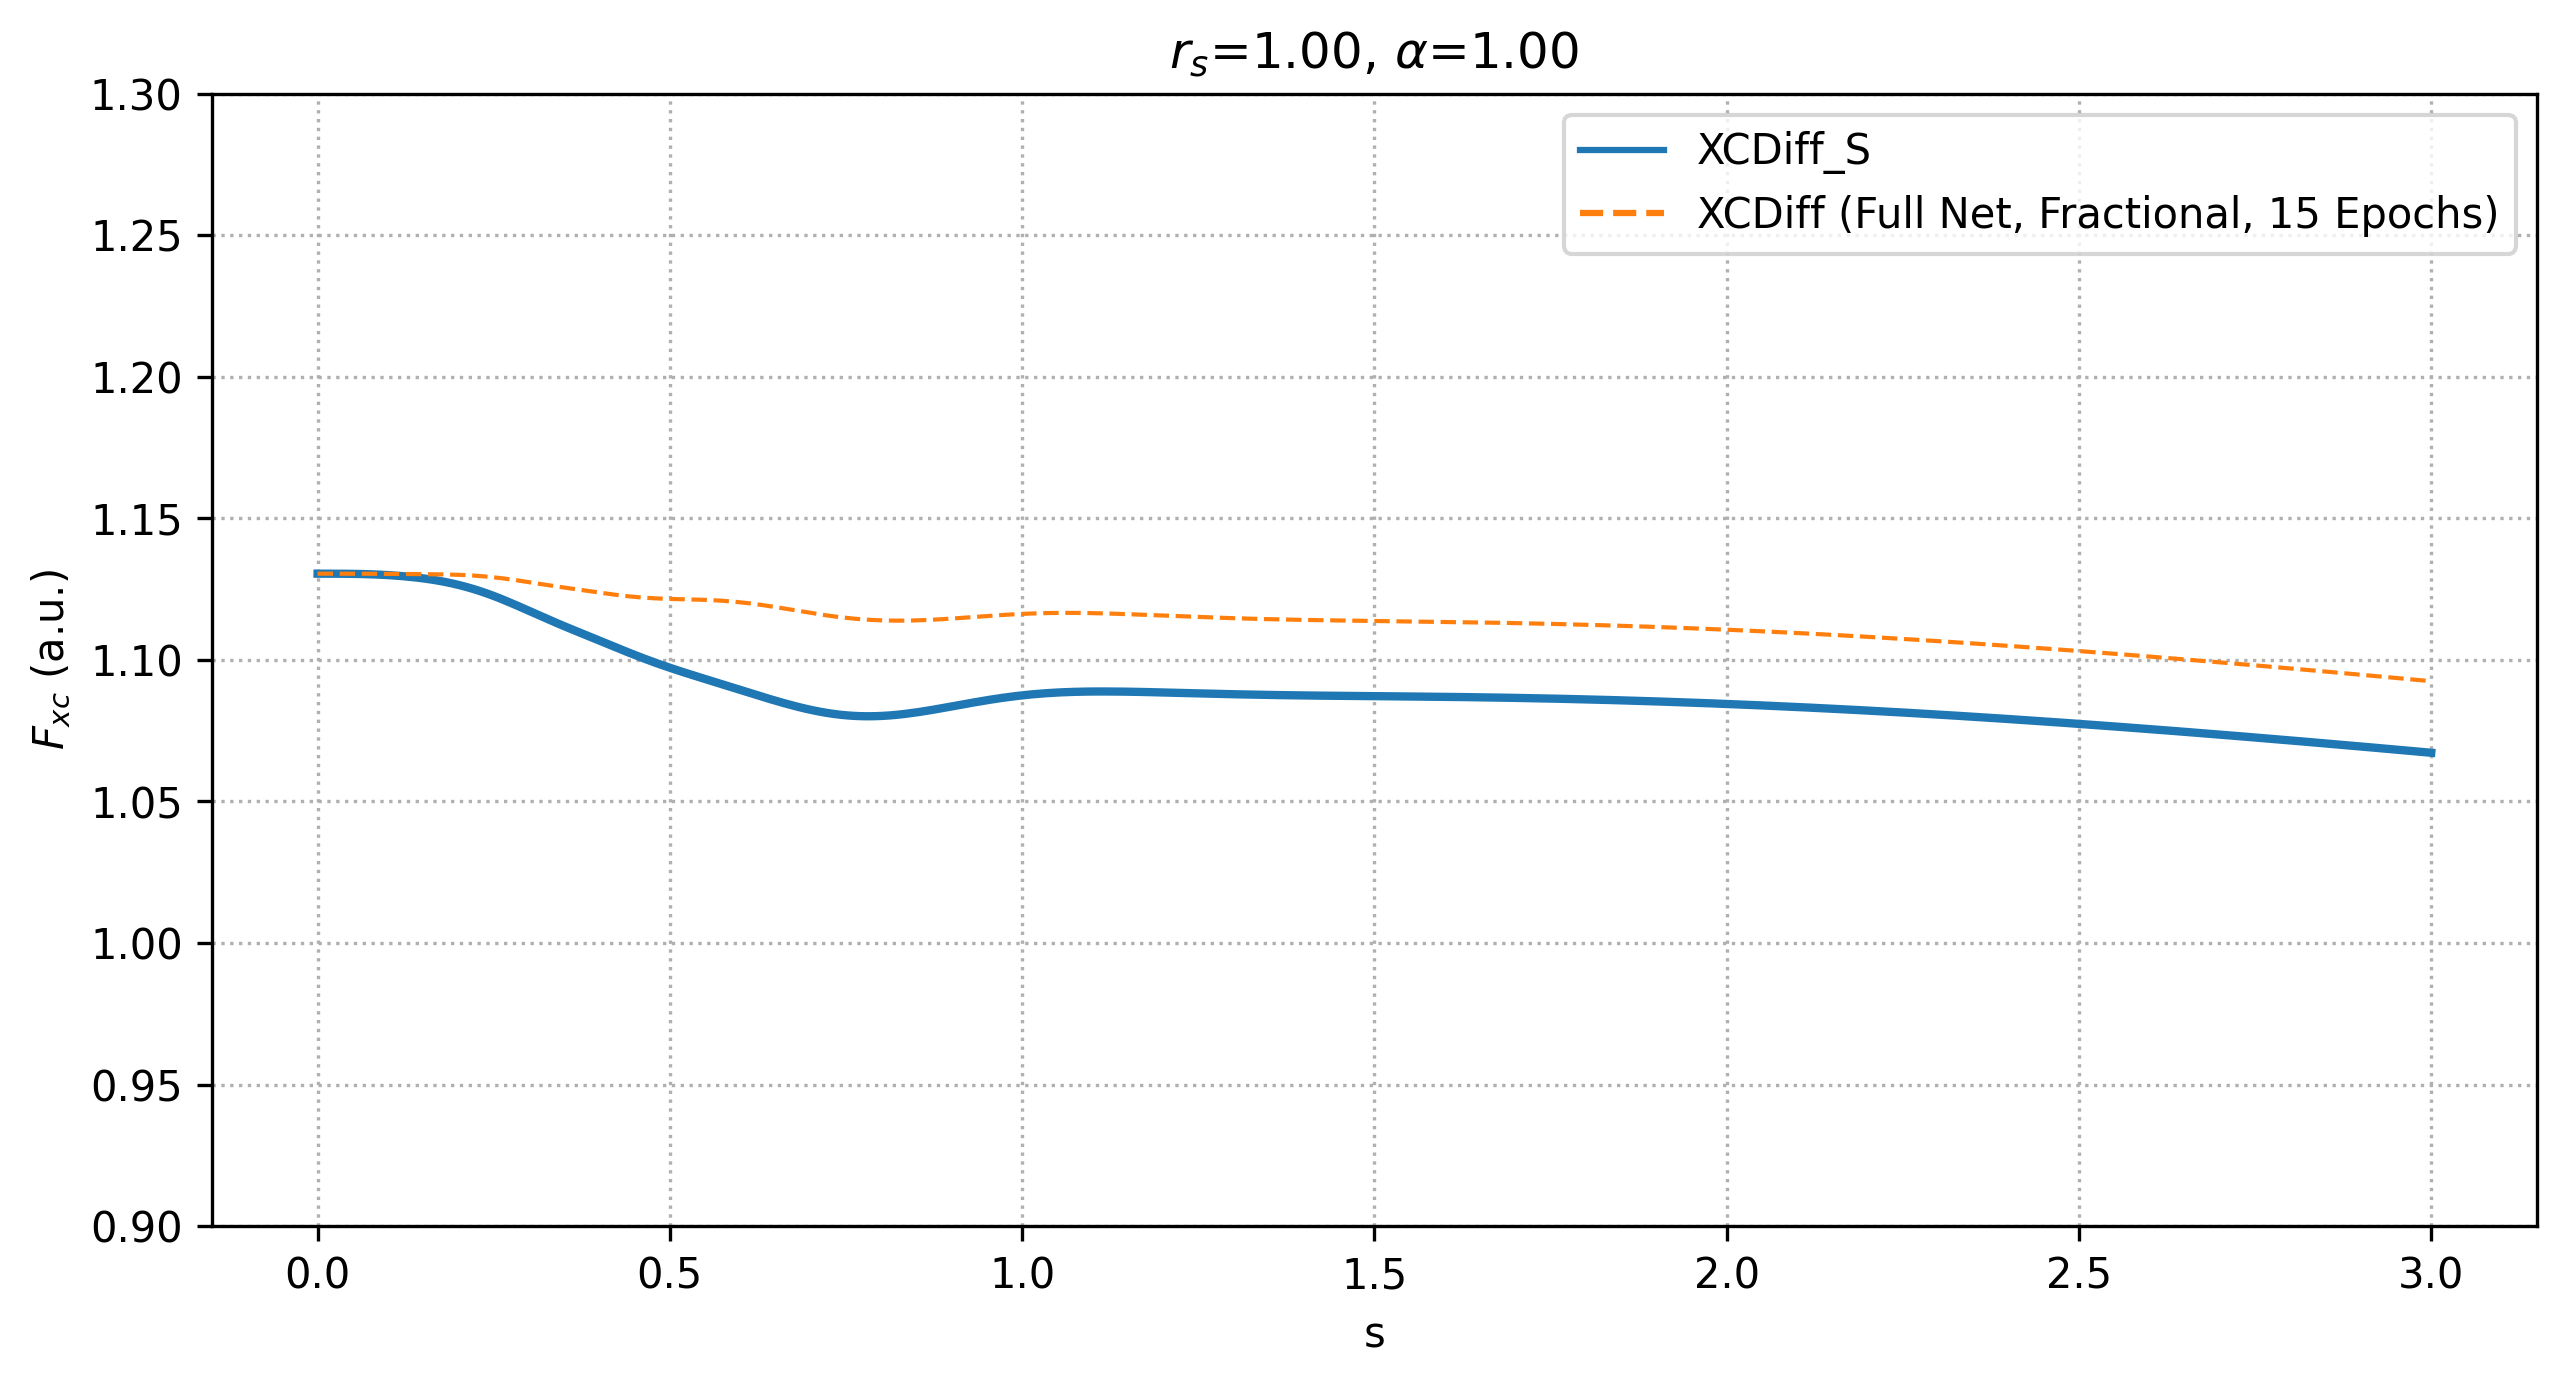

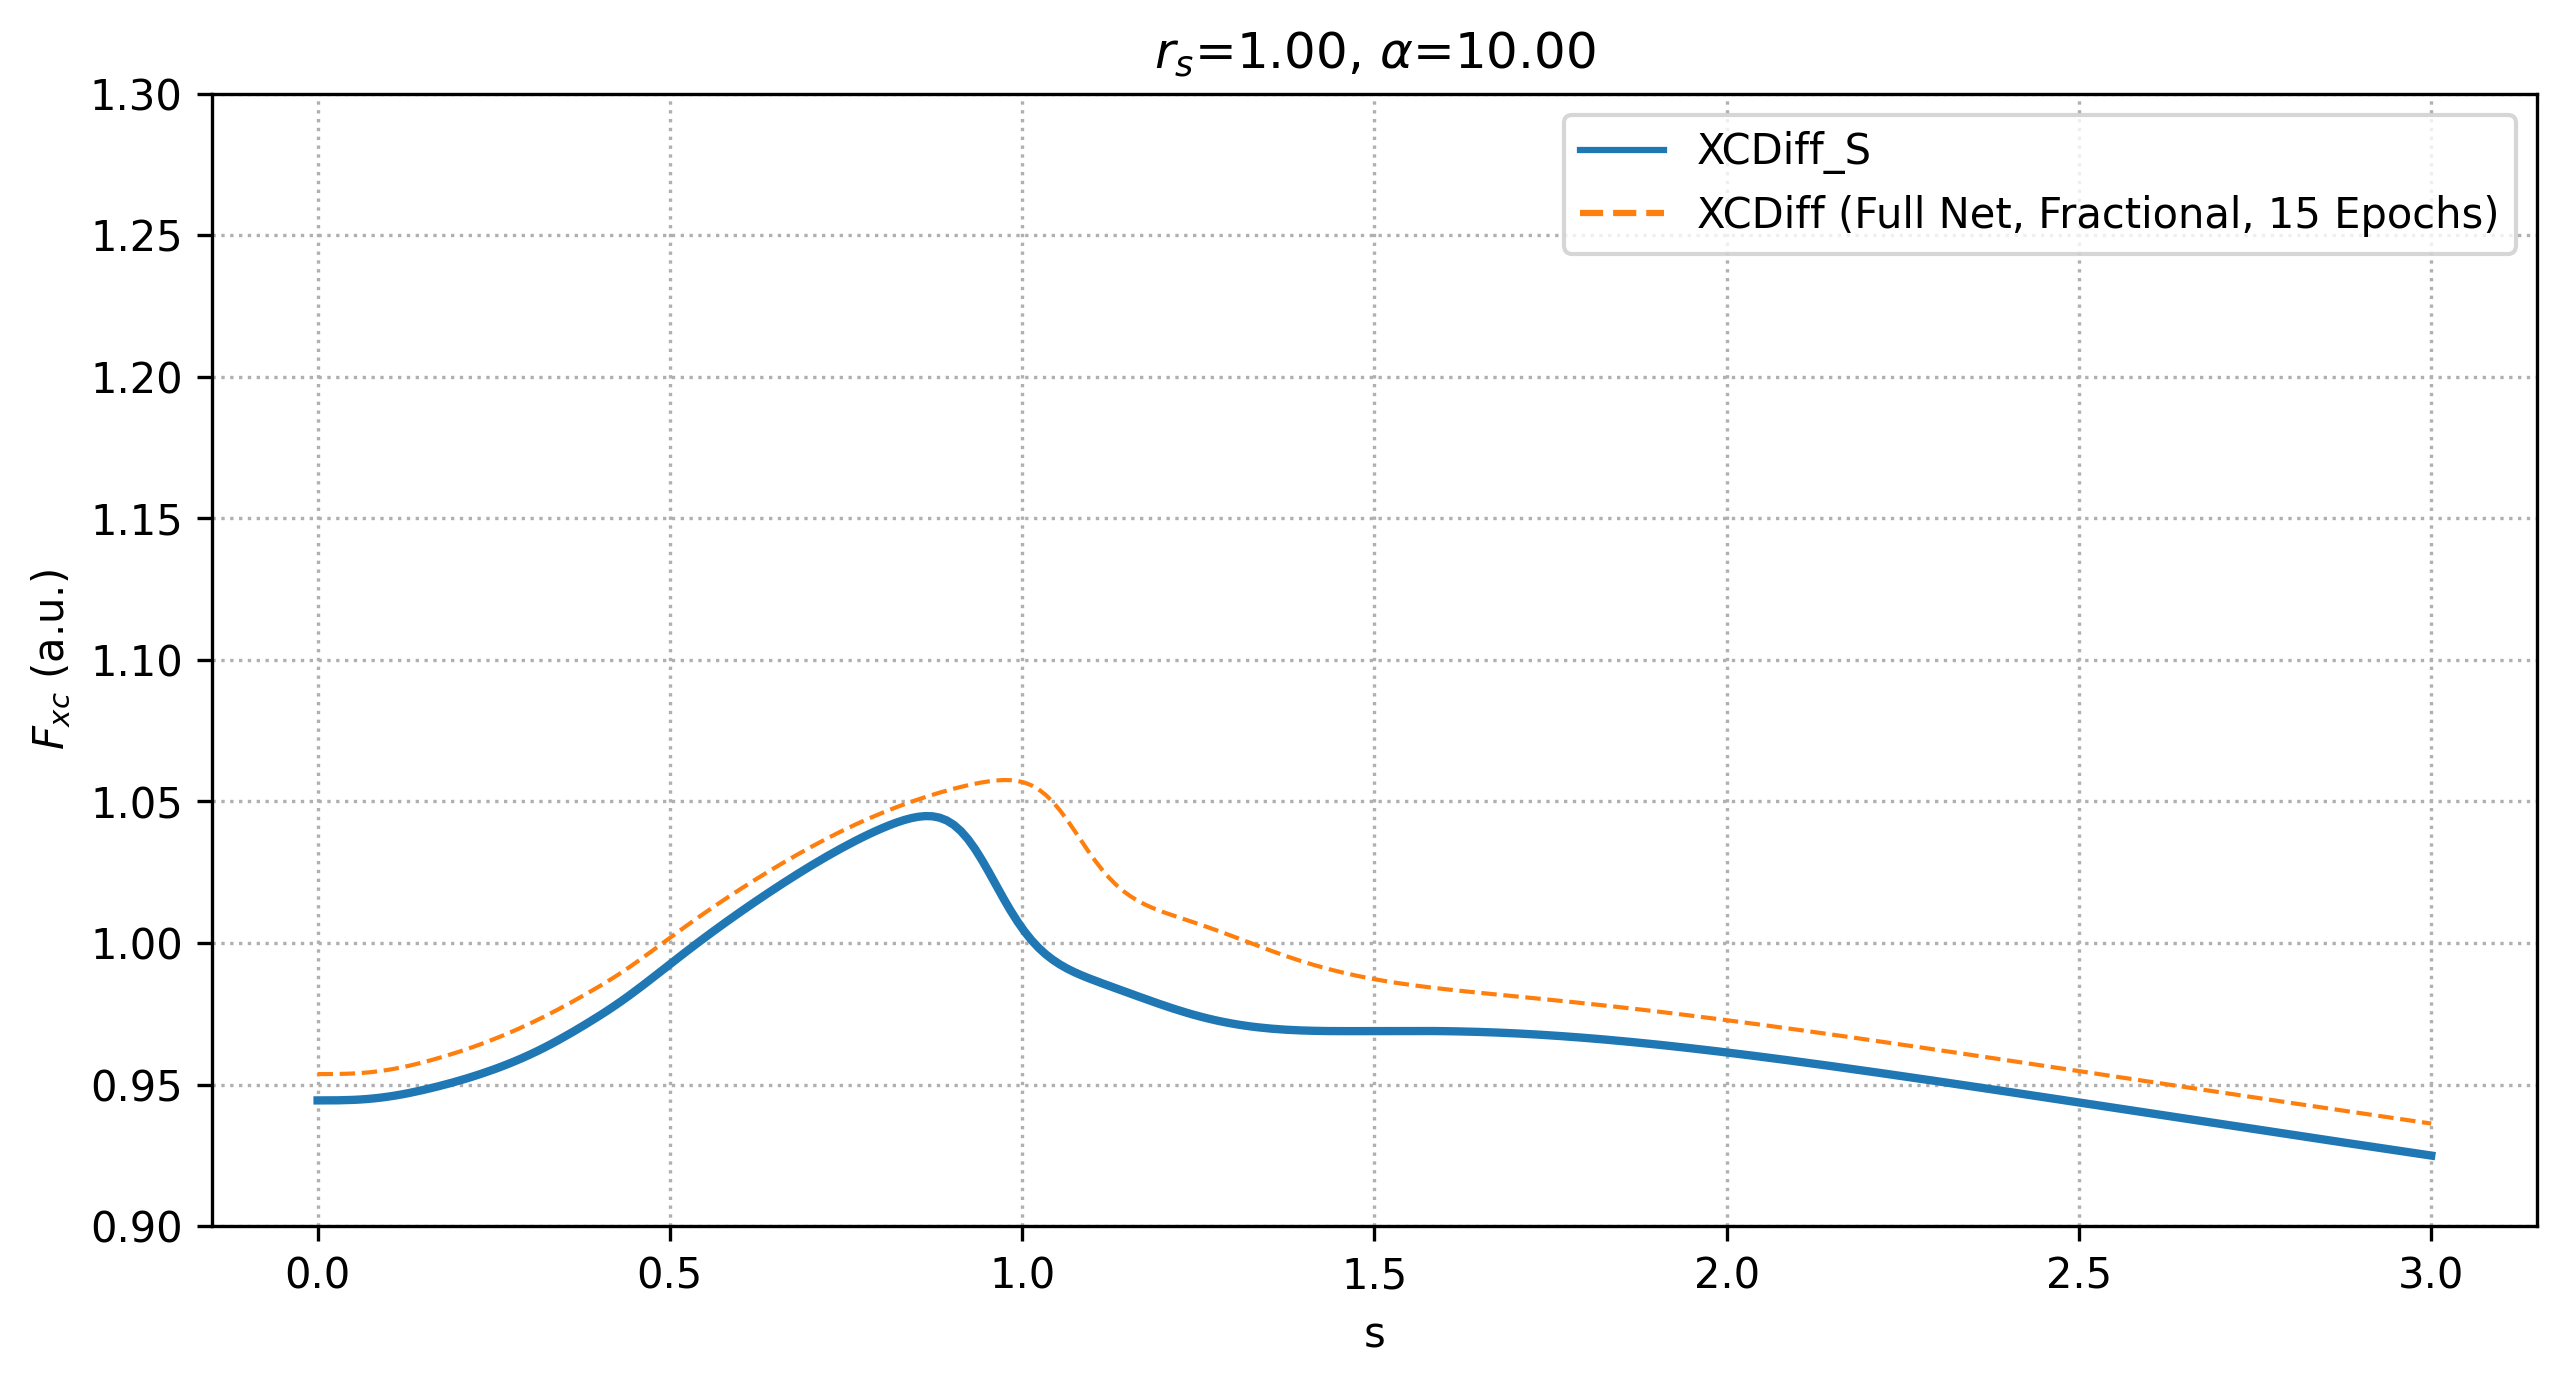

In [16]:
figsize(10,5)

figure(dpi=300)
modelroot = '/home/awills/Documents/Research/swxcd/eval'
xcdsd = '/home/awills/Documents/Research/swxcd/train/xcdiffsym'
xcdsfp = '/home/awills/Documents/Research/swxcd/train/xcdsymfrac'
xcd = torch.jit.load(os.path.join(modelroot, 'xcdiff/MODEL_MGGA/xc'))
xcd4pc2 = torch.load(os.path.join(xcdsd, 'lr1en4_pc2', 'xc'))
xcdsf = torch.load(os.path.join(xcdsfp, 'xc'))

only = None
ylims=(0.9, 1.3)
dct = {"XCDiff_S": xcd, 
      #"XCDiff (Continued, LR=1e-4 (pc2))":xcd4pc2.xc,
       "XCDiff (Full Net, Fractional, 15 Epochs)":xcdsf.xc}

plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[0], only=only)
ylim(ylims)
# legend([])
grid(ls=':')
title("$r_s$={:3.2f}, $\\alpha$={:3.2f}".format(1, 0))

# savefig('Fxc_mgga_alpha0.pdf',bbox_inches='tight')
figure(dpi=300)
plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[1], only=only)
ylim(ylims)
title("$r_s$={:3.2f}, $\\alpha$={:3.2f}".format(1, 1))

# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha1.pdf',bbox_inches='tight')
figure(dpi=300)
plot_fxc(dct, s_range=[0, 3], rs=[1], alpha_range=[10], only=only)
title("$r_s$={:3.2f}, $\\alpha$={:3.2f}".format(1, 10))
ylim(ylims)
# legend([])
grid(ls=':')
# savefig('Fxc_mgga_alpha10.pdf',bbox_inches='tight')